In [208]:
import io
!pip install librosa
!pip install pytorch
!pip install tabulate

  Running setup.py bdist_wheel for pytorch ... error
  Complete output from command /home/karol/miniconda3/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-dq58qe/pytorch/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-pbtoxR --python-tag cp27:
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-install-dq58qe/pytorch/setup.py", line 17, in <module>
      raise Exception(message)
  Exception: You should install pytorch from http://pytorch.org
  
  ----------------------------------------
  Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
  Running setup.py install for pytorch ... error
    Complete output from command /home/karol/miniconda3/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-dq58qe/pytorch/setup.py';f=getattr(tokeniz

In [3]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy
import os
import torch
from warpctc_pytorch import CTCLoss
from ctcdecode import CTCBeamDecoder
import itertools
import random
from collections import Counter
from tabulate import tabulate
import sys
from __future__ import print_function

In [4]:
#Functions for file manipulation
def load_samples(file_path):
    ys, srs = [[]],[[]]
    i = 0
    #loads .wav files
    for filename in os.listdir(file_path):
        if filename.endswith(".wav"):
            y, sr = librosa.load(file_path+filename, sr=16000)
            ys[i].append(y)
            srs[i].append(sr)
            i = i + 1
            ys.append([])
            srs.append([])  
    ys = ys[0: len(ys) - 1]
    srs = srs[0: len(srs) - 1]
    return (ys, srs)


def load_labels(file_path):
    i = 0
    labels = [[]]
    
    for filename in os.listdir(file_path):
        if filename.endswith(".txt"):
            file = open(file_path+filename, "r") 
            labels[i].append(file.read())
            labels.append([])
            i = i + 1
            
    labels=labels[0: len(labels) - 1]
    return labels

In [5]:
#Functions for feature extraction
def find_max(ys):
    """
    Searches for the longest same.
    used for padding.
    ys - [num_samples] x [sample_length]
    
    returns
    max(sample_length)
    """
    
    maximum =0
    for y1 in ys:
        for y2 in y1:
            dim = y2.shape[0]
            if dim > maximum:
                maximum = dim
    return maximum

def pad_signal(ys, max_length):
    """
    pads the signal
    
    Signals are not of the same length, so samples that are shorter then longest signal are padded
    ys - [num_samples] x [sample_length]
    
    returns
    [num_samples] x [sample_length] - sample_length is now same for each sample
    """
    
    
    ys_new = ys
    for i, y1 in enumerate(ys_new):
        for j, y2 in enumerate(y1):
            if len(y2) < max_length:
                z = numpy.zeros((max_length - len(y2)))
                pad_signal = numpy.append(y2, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
                ys_new[i][j] = pad_signal
    return ys_new
def pre_emphasize(ys, pre_emphasis = 0.97):
    """
    Performs pre emphasis
    
    ys - ys - input array of all samples [num_samples] x [sample_length]
    pre_emphasis - pre emphasis factor, usually 0.97
    
    returns
    [num_samples] x [sample_length] - emphasized signal
    """
    for i, y in enumerate(ys):
        signal=y[0]
        y[0] = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    return ys
def fourier_transform(ys, N_FFT=512, window='hamming', hop_size=256):
    """
    Performs stft
    
    ys - input array of all samples [num_samples] x [sample_length]
    N_FFT - number of FFTs
    window - window function - e.g. hanning, or hamming etc.
    hop_size - self explanatory
    
    returns Ds [num_samples] x [1] x [sequence_length] x [N_FFT/2 + 1] - returns spectrogram of the sample. It is a bit stupid, since there is one extra
    unncessary dimension, it`s mostly because working with numpy arrays is ... 
    
    """
    
    Ds = [[]]

    for i, y in enumerate(ys):
        Ds[i].append(librosa.core.stft(y=y[0], n_fft=N_FFT, window=window, hop_length=hop_size))
        Ds.append([])
    return Ds

def mfccs(ys, N_FFT=512, sr=16000, n_mfcc=40, hop_size=256):
    """
    Extracts mel features
    
    ys - input array of all samples [num_samples] x [sample_length]
    N_FFT - number of FFTs
    sr - sampling rate
    n_mfcc - number of mfcc features
    hop_size - self explanatory
    
    returns
    mels [num_samples] x [1] x [sequence_length] x [n_mfcc] - returns mel features. It is a bit stupid, since there is one extra
    unncessary dimension, it`s mostly because working with numpy arrays is ...
    """
    mels = [[]]
    
    for i, y in enumerate(ys):
        mels[i].append(librosa.feature.mfcc(y[0], sr=sr, n_mfcc=n_mfcc, n_fft=N_FFT, hop_length=hop_size))
        mels.append([])
    return mels

In [6]:
def display_cost(costs, num_epochs):
    print(len(costs))
    x = numpy.arange(0, num_epochs, 1)
    print(len(x))
    print(num_epochs)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Cost")
    ax.plot(x, costs)
    plt.show()

def display_cost_eval(costs, num_epochs, eval_eps):
    print(len(costs))
    x = numpy.arange(0, num_epochs, eval_eps)
    print(len(x))
    print(num_epochs)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Cost")
    ax.plot(x, costs)
    plt.show()
    

def greedy_decoder(outs, all_labels):
    """
    """
    
    outputs=outs
    string=[]
    maximals, indices = outputs.max(1)
    for i in indices:
        string.append(all_labels[i])
    itertools.groupby(string)
    string=[k for k, g in itertools.groupby(string)]
    output =[]
    for s in string:
        if s != "-":
            output.append(s)
    
    #print(output)
    return output

def WER(predicted, ground_truth):
    arr=numpy.zeros([len(predicted) + 1, len(ground_truth) + 1])
    
    
    i = 0
    while i < len(arr):
        j = 0
        
        while j < len(arr[i]):
            if i == 0:
                arr[0][j] = j
            elif j == 0:
                arr[i][0] = i
    
            j = j + 1
        i = i + 1
        
    i = 1
    while i < len(arr):
        
        j = 1
        while j < len(arr[i]):
            if predicted[i - 1] == ground_truth[j - 1]:
                arr[i][j] = arr[i - 1][j - 1]
            else:
                replace = arr[i-1][j-1] + 1
                insert  = arr[i][j-1]   + 1
                delete  = arr[i-1][j]   + 1
                arr[i][j]=min(replace, insert, delete)
            j = j + 1
        i = i + 1
    
    return arr[len(predicted)][len(ground_truth)]/len(predicted.split())

def add_string_to_histogram(hist, string_in):
    for i in string_in:
        if(i == " "):
            hist[26] +=1
        else:
            #print(ord(i))
            hist[ord(i) - 65] += 1
    
    return hist

def plot_histogram(histogram):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    names =  ['A','B','C','D', 'E','F', 'G', 'H', 'I', 'J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z', ' ']
    x_coordinates = numpy.arange(len(histogram))
    ax.bar(x_coordinates, histogram, align='center')
    ax.xaxis.set_major_locator(plt.FixedLocator(x_coordinates))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(names))
    plt.show()
    
def prediction_comparator(matrix, truth, predicted):
    """
    matrix [28]x[28] matrix where one index is for truth and another for predicted
    """
    
    if len(truth) > len(predicted):
        i = 0
        while i < len(predicted):
            c1 = truth[i]
            c2 = predicted[i]
            if (c1 == " "):
                index1 = 26
            else:
                index1 = ord(c1) - 65
            
            if(c2 == " "):
                index2 = 26
            else:
                index2 = ord(c2) - 65
            matrix[index1][index2] += 1
            i = i +1
        while i < len(truth):
            c1 = truth[i]
            if (c1 == " "):
                index1 = 26
            else:
                index1 = ord(c1) - 65
             
            matrix[index1][27] += 1
            i = i + 1
    else:
        i = 0
        while i < len(truth):
            c1 = truth[i]
            c2 = predicted[i]
            if (c1 == " "):
                index1 = 26
            else:
                index1 = ord(c1) - 65
            
            if(c2 == " "):
                index2 = 26
            else:
                index2 = ord(c2) - 65
            matrix[index1][index2] += 1
            i = i +1
        while i < len(predicted):
            c2 = predicted[i]
            if(c2 == " "):
                index2 = 26
            else:
                index2 = ord(c2) - 65
            matrix[27][index2] += 1
            i = i + 1
    return matrix

def print_comparisons(matrix):
    letters =  ['A', 'B','C','D', 'E','F', 'G', 'H', 'I', 'J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z', ' ', '-']
    
    header1 = "  [A"

    for i, character in enumerate(letters):
        if(i > 0):
            header1 = header1 + ", " + character

    print(header1)
    
    for i, item in enumerate(matrix):
        print(letters[i], end=" ")
        print(item)

# Step 1
* we open the samples and labels

In [7]:
path = "an4_dataset/train/"#path to the dataset

ys, srs = load_samples(path)
labels = load_labels(path)

In [8]:
path2 = "an4_dataset/validation/"

ys_valid, srs = load_samples(path2)
labels_valid = load_labels(path2)

# Step 2
* loaded data is preprocessed
* we perform stft using librosa
* then we add melspectrogram
* and MFCCs, all are prepared, but we can use each of them, so we get different kinds of features

**Note**: For stft we have a window size, typically 512 or 256 and hop size. On each iteration we start at 
$$
n_1 = N_f x H
$$
and we finish at
$$
n_2 = n_1 + M - 1
$$

https://dsp.stackexchange.com/questions/38491/time-position-in-stft-output

H is a hop size (length) and M is a window size.

In [9]:
train_max=find_max(ys=ys)
valid_max=find_max(ys=ys_valid)
max_len= train_max if train_max>valid_max else valid_max

ys_new = pad_signal(ys, max_len)
ys_valid_new=pad_signal(ys_valid, max_len)

ys_emphasized=pre_emphasize(ys_new, 0.97)
ys_valid_emphasize=pre_emphasize(ys_valid_new, 0.97)

In [10]:
N_FFT = 400 #window size
window = 'hamming'
hop_size = 160
N_MFCC = 13

#Ds=fourier_transform(ys=ys_emphasized, N_FFT=N_FFT, window=window, hop_size=hop_size)
Ms=mfccs(ys=ys_emphasized, n_mfcc=N_MFCC, N_FFT=N_FFT, hop_size=hop_size)
Ms_valid=mfccs(ys=ys_valid_emphasize, n_mfcc=N_MFCC, N_FFT=N_FFT, hop_size=hop_size)

[310, 189, 85, 149, 2253, 573, 300, 619, 1027, 55, 70, 173, 101, 1177, 1131, 153, 30, 876, 672, 1426, 439, 455, 387, 273, 356, 81, 4494]


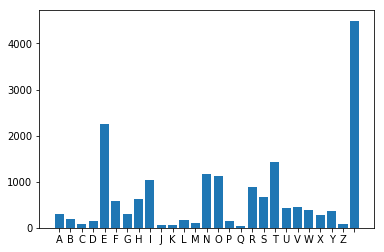

In [11]:
hist_labels = [0]*27
#print(hist_labels)
for s in labels:
    #print(s)
    hist_labels=add_string_to_histogram(hist_labels, ''.join(s))
print(hist_labels)


plot_histogram(hist_labels)

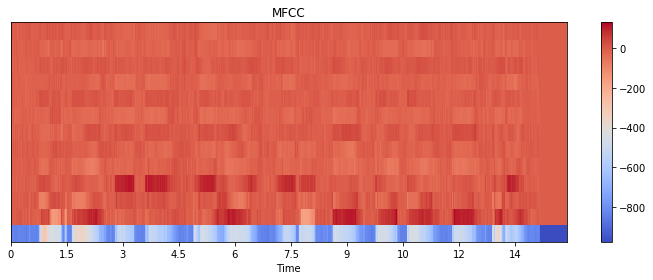

In [12]:
#Here we plot mel spectrogram of one of the samples. Since this sample is pretty 
#long, we have something over the whole time period
plt.figure(figsize=(10, 4))
librosa.display.specshow(Ms[1][0], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()


# Step 3

Here we create a neural network, define loss function (CTCLoss in our case) and optimizer.

In [13]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool1d, Dropout2d, Conv1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [14]:
# hyperameters of the model
num_classes = 28
channels = N_MFCC
height = 641
width = N_MFCC

num_filters_conv1 = 100
kernel_size_conv1 = 11 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
padding_conv1 = 0
dilation_conv1 = 2

stride_pool1 = 2
kernel_size_pool1 = 2
padding_pool1 = 0
dilation_pool1 = 2

#convolutional layer
num_filters_conv2 = 100
kernel_size_conv2 = 11 # [height, width]
stride_conv2 = 1 # [stride_height, stride_width]
padding_conv2 = 0
dilation_conv2 = 1

stride_pool2 = 2
kernel_size_pool2 = 2
padding_pool2 = 0
dilation_pool2 = 1

#3rd convolutional layer
num_filters_conv3 = 100
kernel_size_conv3 = 9 # [height, width]
stride_conv3 = 1 # [stride_height, stride_width]
padding_conv3 = 0
dilation_conv3 = 1


stride_pool3 = 2
kernel_size_pool3 = 2
padding_pool3 = 0
dilation_pool3 = 1

#4th convolutional layer
num_filters_conv4 = 100
kernel_size_conv4 = 9 # [height, width]
stride_conv4 = 1 # [stride_height, stride_width]
padding_conv4 = 0
dilation_conv4 = 1

#5th convolutional layer
num_filters_conv5 = 100
kernel_size_conv5 = 5 # [height, width]
stride_conv5 = 1 # [stride_height, stride_width]
padding_conv5 = 0
dilation_conv5 = 1

#6th convolutional layer
num_filters_conv6 = 100
kernel_size_conv6 = 5 # [height, width]
stride_conv6 = 1 # [stride_height, stride_width]
padding_conv6 = 0
dilation_conv6 = 1

#7th convolutional layer
num_filters_conv7 = 100
kernel_size_conv7 = 5 # [height, width]
stride_conv7 = 1 # [stride_height, stride_width]
padding_conv7 = 0
dilation_conv7 = 1



#8th convolutional layer
num_filters_conv8 = 100
kernel_size_conv8 = 3 # [height, width]
stride_conv8 = 1 # [stride_height, stride_width]
padding_conv8 = 0
dilation_conv8 = 1

#9th convolutional layer
num_filters_conv9 = 100
kernel_size_conv9 = 3 # [height, width]
stride_conv9 = 1 # [stride_height, stride_width]
padding_conv9 = 0
dilation_conv9 = 1


#10th convolutional layer
num_filters_conv10 = 100
kernel_size_conv10 = 3 # [height, width]
stride_conv10 = 1 # [stride_height, stride_width]
padding_conv10 = 0
dilation_conv10 = 1

#11th convolutional
num_filters_conv11 = 400
kernel_size_conv11 = 1
stride_conv11 = 1
padding_conv11 = 0
dilation_conv11 = 1

num_filters_conv12 = 28
kernel_size_conv12 = 1
stride_conv12 = 1
padding_conv12 = 0
dilation_conv12 = 1

batch_size=40
num_l1 = 512
dilation=1

def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

def compute_maxPool_dim(dim_size):
    return int((dim_size - kernel_size_pool1 + 2 * padding_conv1) / stride_pool1 + 1)


def compute_conv_dim_1d(L_in, kernel_in, padding_in = 0, dilation_in = 1, stride_in = 1):
    return int((L_in + 2*padding_in - dilation_in*(kernel_in - 1) - 1)/stride_in + 1)

def compute_conv_height_2d(H_in, kernel_size_height, padding_height=0, dilation_height=1, stride_height=1):
    return int((H_in+2*padding_height-dilation_height*(kernel_size_height - 1) - 1)/stride_height + 1)

def compute_conv_width_2d(W_in,  kernel_size_width, padding_width=0, dilation_width=1, stride_width=1):
    return int((W_in+2*padding_width-dilation_width*(kernel_size_width-1) - 1)/stride_width + 1)

def compute_pool_dim_1d(L_in, kernel_in, padding_in = 0, dilation_in = 1, stride_in = 1):
    return int((L_in + 2*padding_in - dilation_in*(kernel_in - 1) - 1)/stride_in + 1)
    
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #out_dim = (input_dim - filter_dim + 2 * padding) / stride + 1
        self.conv_1 = Conv1d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1,
                             dilation=dilation_conv1)
        
        
        
        self.conv_dim_1=compute_conv_dim_1d(L_in=height, kernel_in=kernel_size_conv1,padding_in=padding_conv1,
                        dilation_in=dilation_conv1, stride_in=stride_conv1)
        self.conv_dropout_1=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_1=torch.nn.BatchNorm1d(num_filters_conv1)
        
        self.conv_2 = Conv1d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2,
                             kernel_size=kernel_size_conv2,
                             stride=stride_conv2,
                             padding=padding_conv2,
                             dilation=dilation_conv2)
        
        
        
        
       
        self.conv_dim_2=compute_conv_dim_1d(L_in=self.conv_dim_1, kernel_in=kernel_size_conv2,padding_in=padding_conv2,
                        dilation_in=dilation_conv2, stride_in=stride_conv2)
        
        
        self.conv_dropout_2=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_2=torch.nn.BatchNorm1d(num_filters_conv2)
        
        self.conv_3 = Conv1d(in_channels=num_filters_conv2,
                             out_channels=num_filters_conv3,
                             kernel_size=kernel_size_conv3,
                             stride=stride_conv3,
                             padding=padding_conv3,
                             dilation=dilation_conv3)
        
        
        self.conv_dim_3=compute_conv_dim_1d(L_in=self.conv_dim_2, kernel_in=kernel_size_conv3,padding_in=padding_conv3,
                        dilation_in=dilation_conv3, stride_in=stride_conv3)
        
        
      
        
        self.conv_dropout_3=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_3=torch.nn.BatchNorm1d(num_filters_conv3)
        
        self.conv_4 = Conv1d(in_channels=num_filters_conv3,
                             out_channels=num_filters_conv4,
                             kernel_size=kernel_size_conv4,
                             stride=stride_conv4,
                             padding=padding_conv4,
                             dilation=dilation_conv4)
        
        
        
        
        self.conv_dim_4=compute_conv_dim_1d(L_in=self.conv_dim_3, kernel_in=kernel_size_conv4,padding_in=padding_conv4,
                        dilation_in=dilation_conv4, stride_in=stride_conv4)
        
        self.conv_dropout_4=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_4=torch.nn.BatchNorm1d(num_filters_conv4)
        
        self.conv_5 = Conv1d(in_channels=num_filters_conv4,
                             out_channels=num_filters_conv5,
                             kernel_size=kernel_size_conv5,
                             stride=stride_conv5,
                             padding=padding_conv5,
                             dilation=dilation_conv5)
        
        self.conv_dim_5=compute_conv_dim_1d(L_in=self.conv_dim_4, kernel_in=kernel_size_conv5,padding_in=padding_conv5,
                        dilation_in=dilation_conv5, stride_in=stride_conv5)
          
        
        
        self.conv_dropout_5=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_5=torch.nn.BatchNorm1d(num_filters_conv5)
        
        self.conv_6 = Conv1d(in_channels=num_filters_conv5,
                             out_channels=num_filters_conv6,
                             kernel_size=kernel_size_conv6,
                             stride=stride_conv6,
                             padding=padding_conv6,
                             dilation=dilation_conv6)
        
        self.conv_dim_6=compute_conv_dim_1d(L_in=self.conv_dim_5, kernel_in=kernel_size_conv6,padding_in=padding_conv6,
                        dilation_in=dilation_conv6, stride_in=stride_conv6)
        
        
        self.conv_dropout_6=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_6=torch.nn.BatchNorm1d(num_filters_conv6)
        
        self.conv_7 = Conv1d(in_channels=num_filters_conv6,
                             out_channels=num_filters_conv7,
                             kernel_size=kernel_size_conv7,
                             stride=stride_conv7,
                             padding=padding_conv7,
                             dilation=dilation_conv7)
        
        self.conv_dim_7 = compute_conv_dim_1d(L_in=self.conv_dim_6, kernel_in=kernel_size_conv7,padding_in=padding_conv7,
                        dilation_in=dilation_conv7, stride_in=stride_conv7)
          
        
        self.conv_dropout_7=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_7=torch.nn.BatchNorm1d(num_filters_conv7)
        
        self.conv_8 = Conv1d(in_channels=num_filters_conv7,
                             out_channels=num_filters_conv8,
                             kernel_size=kernel_size_conv8,
                             stride=stride_conv8,
                             padding=padding_conv8,
                             dilation=dilation_conv8)
        
        self.conv_dim_8 = compute_conv_dim_1d(L_in=self.conv_dim_7, kernel_in=kernel_size_conv8,padding_in=padding_conv8,
                        dilation_in=dilation_conv8, stride_in=stride_conv8)
          
        
        
        self.conv_dropout_8=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_8=torch.nn.BatchNorm1d(num_filters_conv8)
        
        
        self.conv_9 = Conv1d(in_channels=num_filters_conv8,
                             out_channels=num_filters_conv9,
                             kernel_size=kernel_size_conv9,
                             stride=stride_conv9,
                             padding=padding_conv9,
                             dilation=dilation_conv9)
        
        self.conv_dim_9 = compute_conv_dim_1d(L_in=self.conv_dim_8, kernel_in=kernel_size_conv9,padding_in=padding_conv9,
                        dilation_in=dilation_conv9, stride_in=stride_conv9)
          
        
        
        self.conv_dropout_9=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_9=torch.nn.BatchNorm1d(num_filters_conv9)
        
        
        self.l1_in_features = num_filters_conv9
        #self.l1_in_features = channels * height * width
        
        self.conv_10 = Conv1d(in_channels=num_filters_conv9,
                             out_channels=num_filters_conv10,
                             kernel_size=kernel_size_conv10,
                             stride=stride_conv10,
                             padding=padding_conv10,
                             dilation=dilation_conv10)
        
        self.conv_dim_10 = compute_conv_dim_1d(L_in=self.conv_dim_9, kernel_in=kernel_size_conv10,padding_in=padding_conv10,
                        dilation_in=dilation_conv10, stride_in=stride_conv10)
          
        
        
        self.conv_dropout_10=torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_10=torch.nn.BatchNorm1d(num_filters_conv10)
        
        self.conv_11 = Conv1d(in_channels=num_filters_conv10,
                             out_channels=num_filters_conv11,
                             kernel_size=kernel_size_conv11,
                             stride=stride_conv11,
                             padding=padding_conv11,
                             dilation=dilation_conv11)
        
        self.conv_dim_11 = compute_conv_dim_1d(L_in=self.conv_dim_10, kernel_in=kernel_size_conv11,padding_in=padding_conv11,
                        dilation_in=dilation_conv11, stride_in=stride_conv11)
          
        
        
        self.conv_dropout_11 = torch.nn.Dropout(p=0.3)
        self.conv_batchnorm_11 = torch.nn.BatchNorm1d(num_filters_conv11)
        
        
        self.conv_12 = Conv1d(in_channels=num_filters_conv11,
                             out_channels=num_filters_conv12,
                             kernel_size=kernel_size_conv12,
                             stride=stride_conv12,
                             padding=padding_conv12,
                             dilation=dilation_conv12)
        
        self.conv_dim_12 = compute_conv_dim_1d(L_in=self.conv_dim_11, kernel_in=kernel_size_conv12,padding_in=padding_conv12,
                        dilation_in=dilation_conv12, stride_in=stride_conv12)
        
        
        
        self.l1_in_features = num_filters_conv10
        
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        
        self.l_1_batchnorm = torch.nn.BatchNorm1d(self.conv_dim_10)
        self.l_1_dropout = torch.nn.Dropout(p=0.2)
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)
    
    def forward(self, x, display_layers=False): # x.size() = [batch, channel, height, width]
        #print(x.shape)
        #(641, 1, 40)
        outs = []
        x = self.conv_1(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_1(x)
        x = self.conv_dropout_1(x)
        
        
        
        x = self.conv_2(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_2(x)
        x = self.conv_dropout_2(x)
        
        
        x = self.conv_3(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_3(x)
        x = self.conv_dropout_3(x)
        
        
        x = self.conv_4(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_4(x)
        x = self.conv_dropout_4(x)
        
        
        x = self.conv_5(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_5(x)
        x = self.conv_dropout_5(x)
        
        
        x = self.conv_6(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_6(x)
        x = self.conv_dropout_6(x)
        
        
        x = self.conv_7(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_7(x)
        x = self.conv_dropout_7(x)
        
        
        x = self.conv_8(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_8(x)
        x = self.conv_dropout_8(x)
    
        
        x = self.conv_9(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_9(x)
        x = self.conv_dropout_9(x)
    
    
        x = self.conv_10(x)
        outs.append(x)
        x = relu(x)
        x = self.conv_batchnorm_10(x)
        x = self.conv_dropout_10(x)
    
    
        x = self.conv_11(x)
        outs.append(x)
        x = self.conv_batchnorm_11(relu(x))
        x = self.conv_dropout_11(x)
        
        x = self.conv_12(x)
        outs.append(x)
        x = x.permute(0, 2, 1)
        
        # torch.Tensor.view: http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        #   Returns a new tensor with the same data as the self tensor,
        #   but of a different size.
        # the size -1 is inferred from other dimensions 
        #print(x.shape)#NCHW to HCNW
        #x=x.permute(0, 2, 1, 3)
        #print(x.shape)
        #x=x.contiguous()
        
        #print(x.shape)
        #x = self.dropout(relu(self.l_1(x)))
        #x = relu(self.l_1(x))
        #print(x.shape)
        if(display_layers):
            return outs, x
        else:
            return x
        #return self.l_out(x)


net = Net()
print(net)

Net(
  (conv_1): Conv1d(13, 100, kernel_size=(11,), stride=(1,), dilation=(2,))
  (conv_dropout_1): Dropout(p=0.3)
  (conv_batchnorm_1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(100, 100, kernel_size=(11,), stride=(1,))
  (conv_dropout_2): Dropout(p=0.3)
  (conv_batchnorm_2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv1d(100, 100, kernel_size=(9,), stride=(1,))
  (conv_dropout_3): Dropout(p=0.3)
  (conv_batchnorm_3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv1d(100, 100, kernel_size=(9,), stride=(1,))
  (conv_dropout_4): Dropout(p=0.3)
  (conv_batchnorm_4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  (conv_dropout_5): Dropout(p=0.3)
  (conv_batchnorm_5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [15]:
criterion = CTCLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Step 4

* In here we prepare the lables - characters A - Z, space and blank character
* number of samples used for training
* number of epochs for the training

In [16]:
num_epochs = 1500
valid_epochs=20
num_samples = 948
all_labels= [
    "-",
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    " ",
]
print(all_labels)
all_labels[0]

['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ']


'-'

# Step 5

* In here we train the network

With batch

Number of epochs: 2
2
2
2


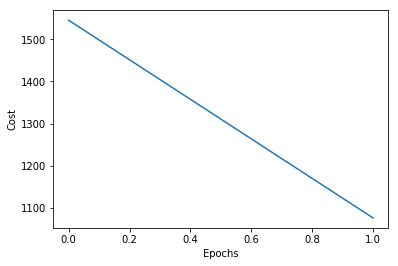

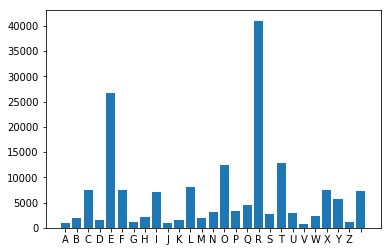

Number of epochs: 4
4
4
4


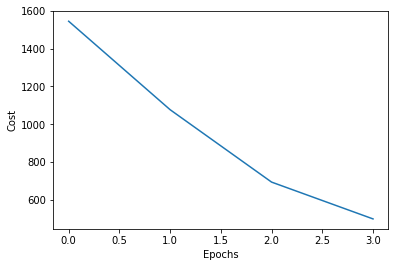

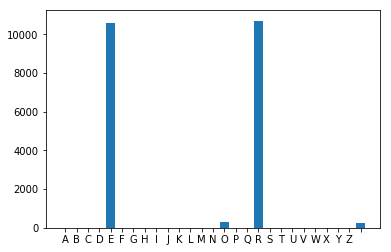

Number of epochs: 6
6
6
6


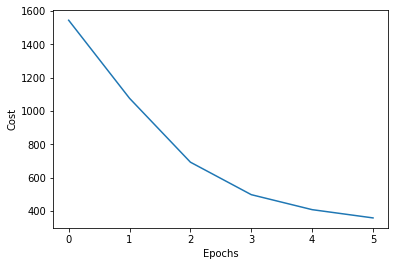

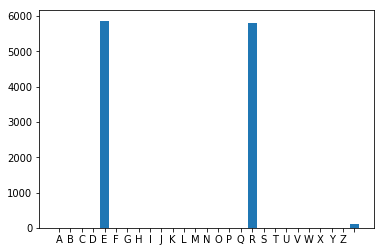

Number of epochs: 8
8
8
8


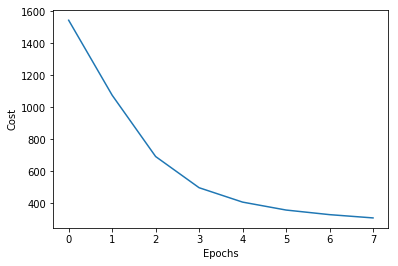

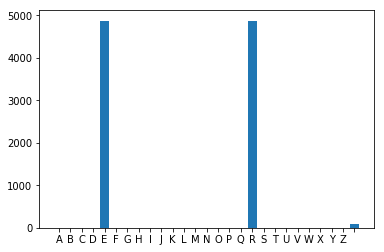

Number of epochs: 10
10
10
10


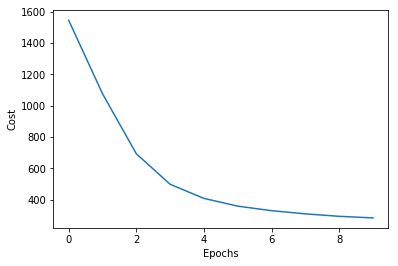

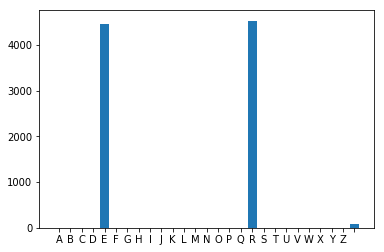

Number of epochs: 12
12
12
12


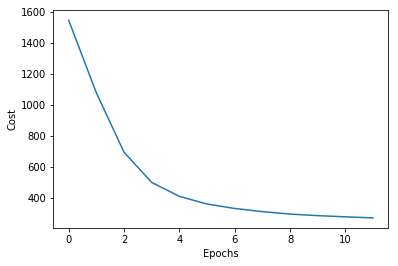

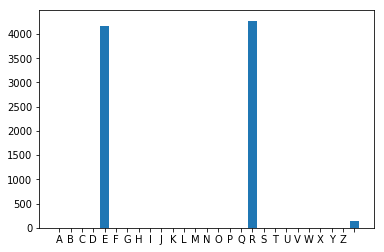

Number of epochs: 14
14
14
14


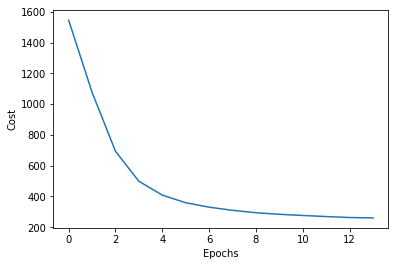

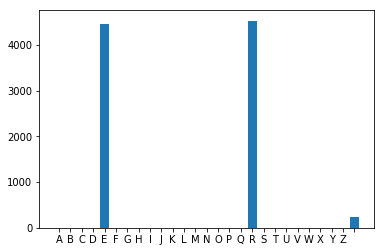

Number of epochs: 16
16
16
16


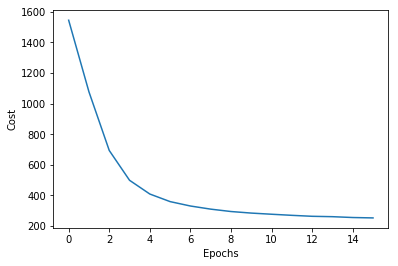

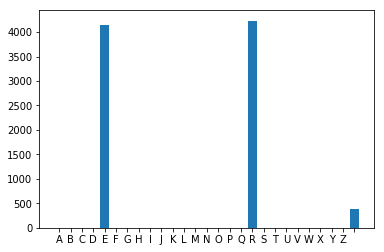

Number of epochs: 18
18
18
18


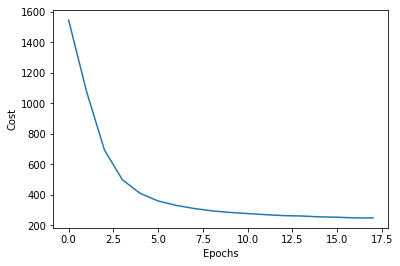

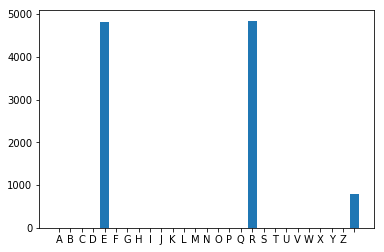

Number of epochs: 20
20
20
20


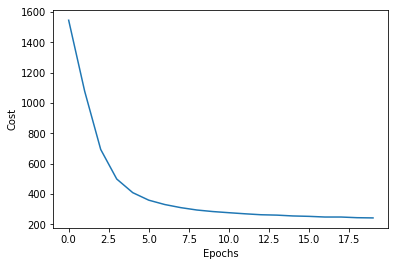

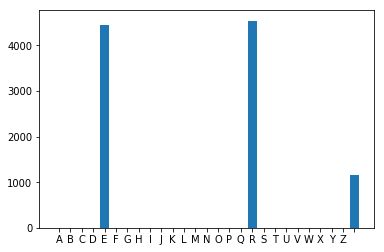

[59, 28, 101, 99, 52, 66, 106, 98, 112, 65, 68, 63, 27, 96, 31, 130, 36, 61, 12, 109, 55, 5, 2, 2, 116, 39, 18, 1, 0, 16, 52, 79, 86, 96, 41, 95, 121, 11, 98, 122]
torch.Size([40, 100, 621])
torch.Size([40, 100, 611])
torch.Size([40, 100, 603])
torch.Size([40, 100, 595])
torch.Size([40, 100, 591])
torch.Size([40, 100, 587])
torch.Size([40, 100, 583])
torch.Size([40, 100, 581])
torch.Size([40, 100, 579])
torch.Size([40, 100, 577])
torch.Size([40, 400, 577])
torch.Size([40, 28, 577])
torch.Size([40, 577, 28])
Predicted:  ER 
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
33.0
Predicted: R
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
37.0
Predicted: R ER
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
Predicted: R  R 
Ground truth: E R I C
WER: 
2.0
Predicted: RE
Ground truth: ENTER NINE TWO EIGHT
WER: 
18.0
Predicted: R
Ground truth: K A U F M A N
WER: 
13.0
Predicted: RE ER
Ground truth: TWO FORTY
WER: 
3.5
Predicted: R 
Ground truth: T R T F I SEVEN
WER: 
13.0

/home/karol/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars


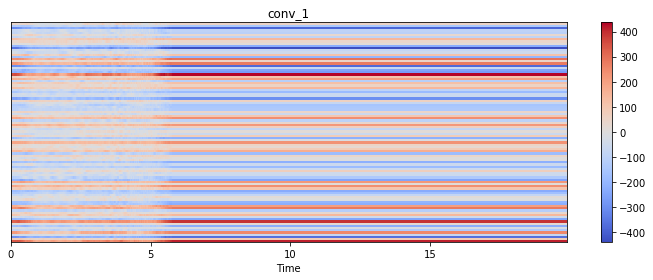

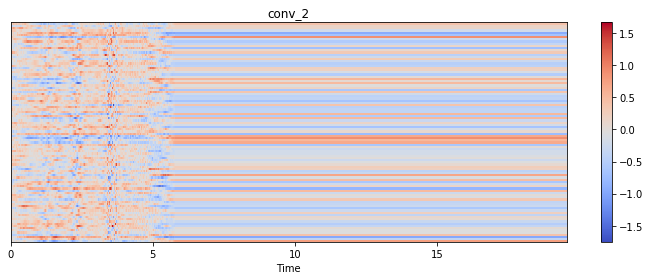

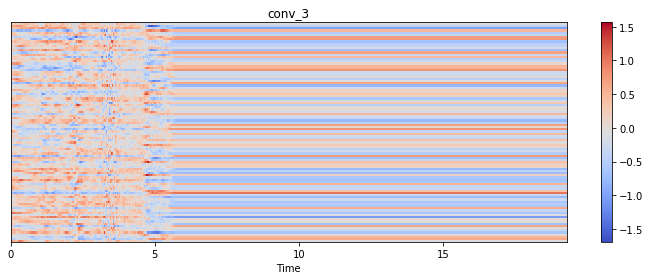

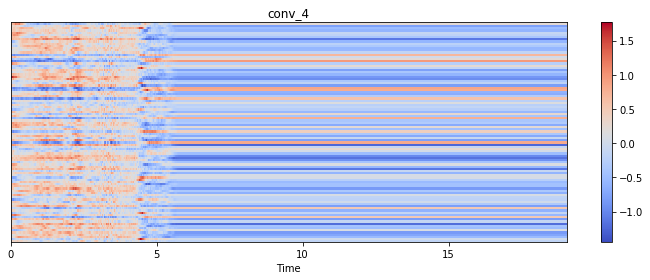

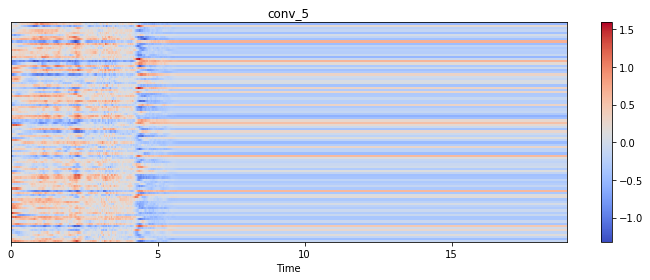

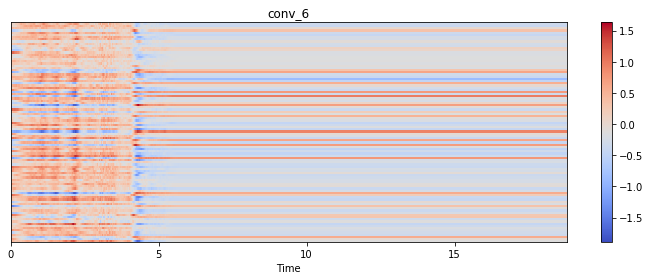

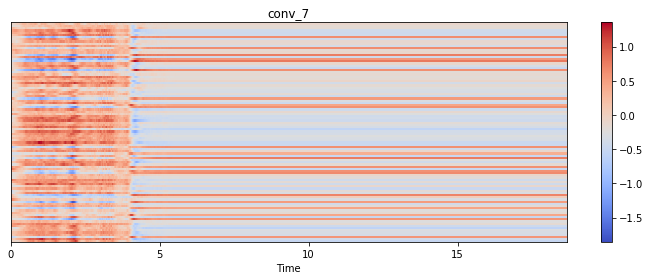

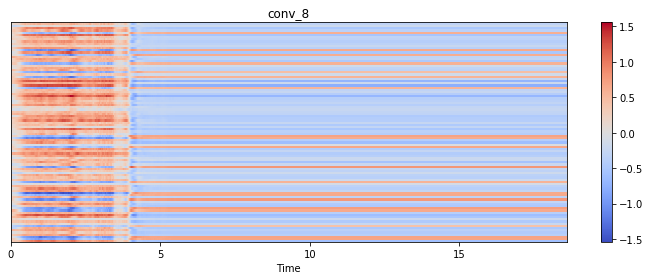

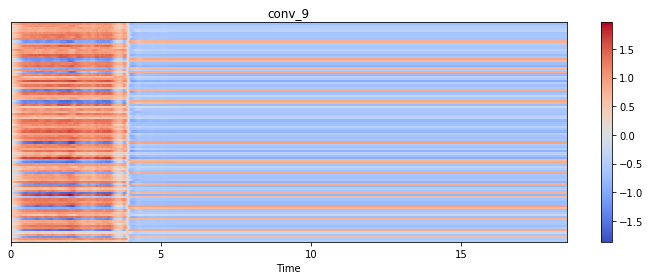

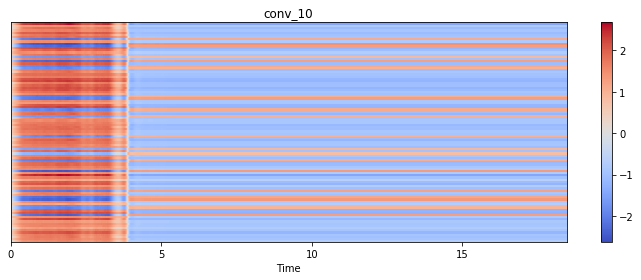

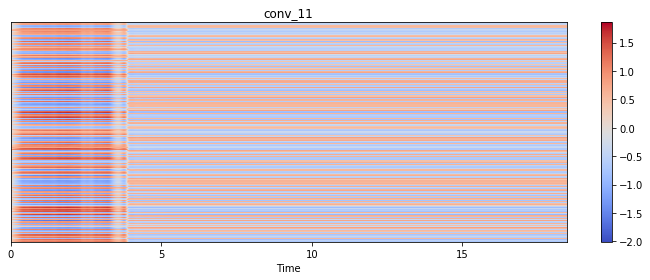

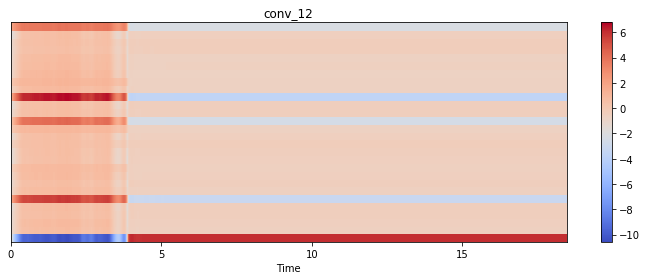

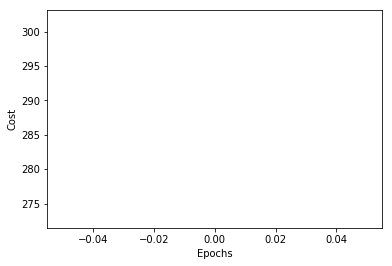

Number of epochs: 22
22
22
22


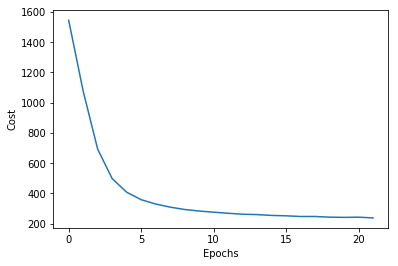

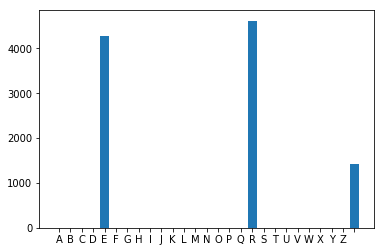

Number of epochs: 24
24
24
24


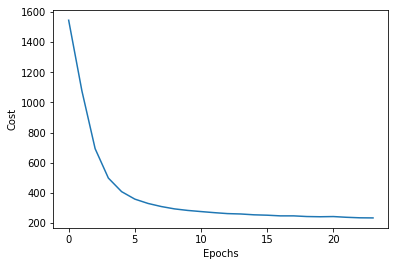

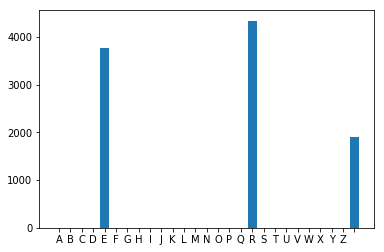

Number of epochs: 26
26
26
26


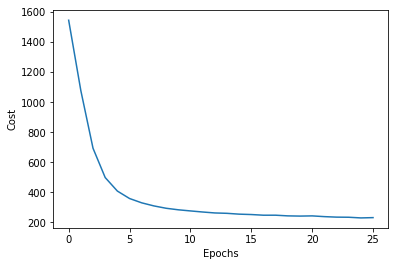

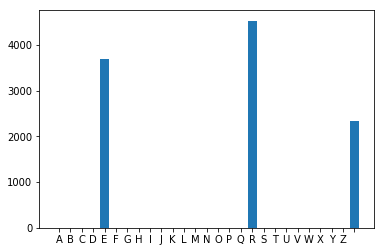

Number of epochs: 28
28
28
28


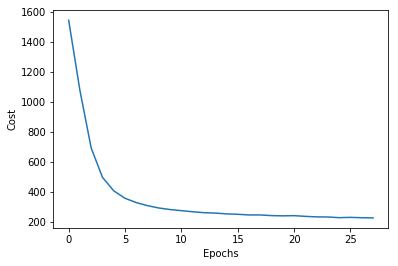

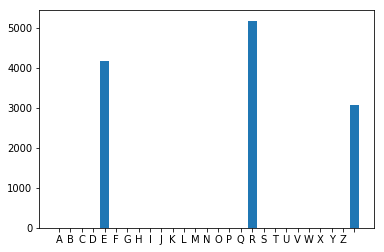

Number of epochs: 30
30
30
30


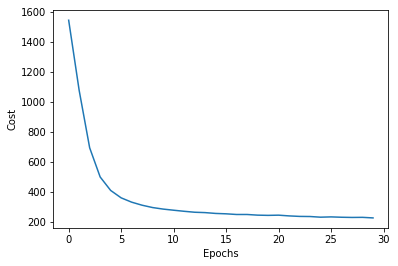

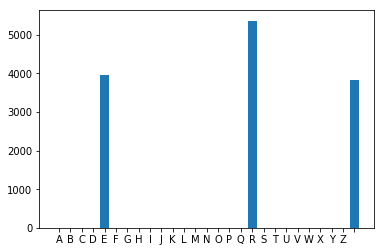

Number of epochs: 32
32
32
32


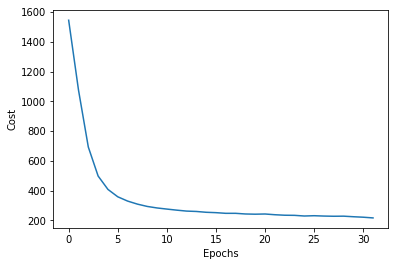

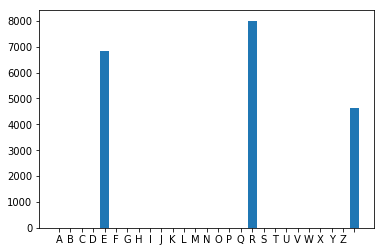

Number of epochs: 34
34
34
34


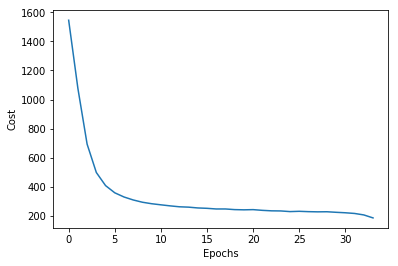

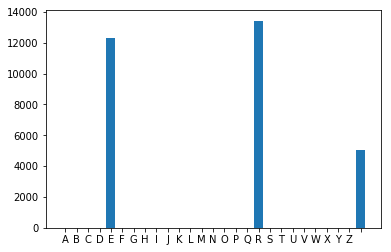

Number of epochs: 36
36
36
36


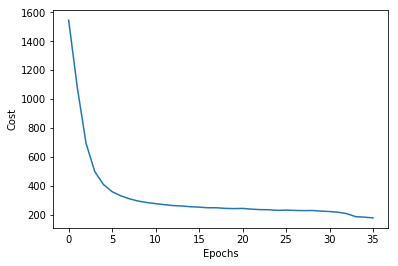

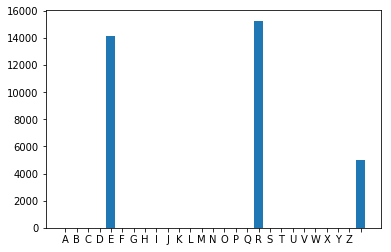

Number of epochs: 38
38
38
38


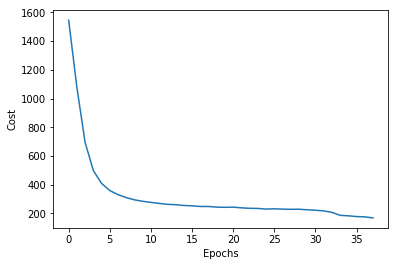

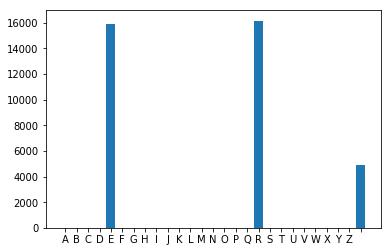

Number of epochs: 40
40
40
40


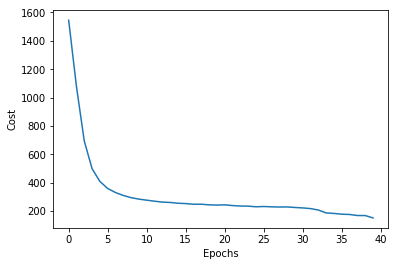

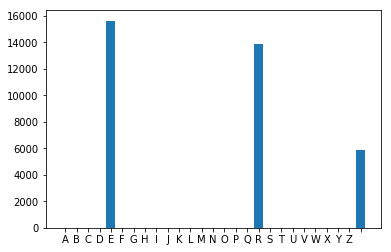

[40, 111, 90, 14, 90, 53, 52, 103, 23, 24, 50, 17, 97, 86, 91, 47, 130, 18, 18, 11, 82, 18, 129, 50, 62, 16, 114, 116, 74, 75, 18, 6, 5, 90, 88, 46, 55, 123, 127, 107]
torch.Size([40, 100, 621])
torch.Size([40, 100, 611])
torch.Size([40, 100, 603])
torch.Size([40, 100, 595])
torch.Size([40, 100, 591])
torch.Size([40, 100, 587])
torch.Size([40, 100, 583])
torch.Size([40, 100, 581])
torch.Size([40, 100, 579])
torch.Size([40, 100, 577])
torch.Size([40, 400, 577])
torch.Size([40, 28, 577])
torch.Size([40, 577, 28])
Predicted: 
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
inf
Predicted:  E 
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
34.0
Predicted:  E 
Ground truth: P L E A S A N T H I L L S
WER: 
22.0
Predicted:  E E  E 
Ground truth: E R I C
WER: 
1.6666666666666667
Predicted:  E  E  E  E 
Ground truth: ENTER NINE TWO EIGHT
WER: 
3.5
Predicted:   E 
Ground truth: K A U F M A N
WER: 
10.0
Predicted:  E  E  E  
Ground truth: TWO FORTY
WER: 
3.0
Predicted: 
Ground 

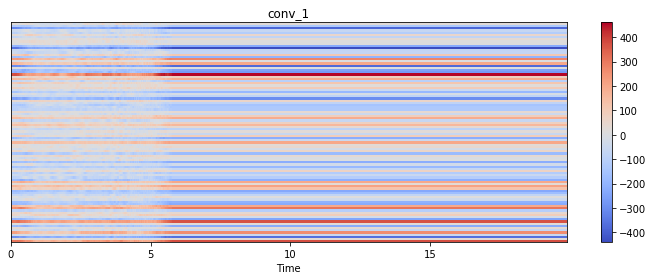

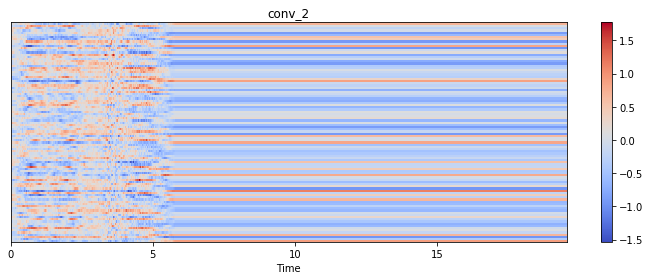

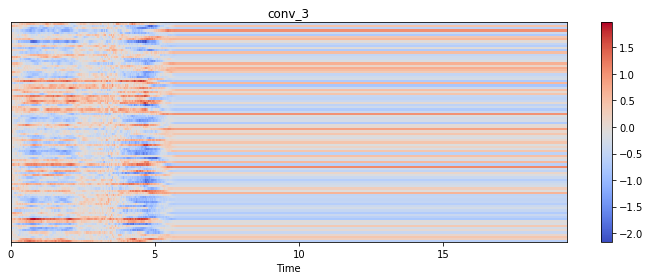

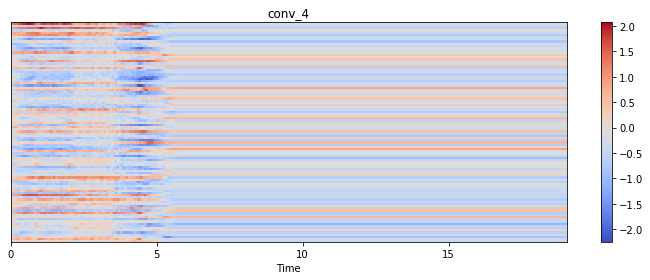

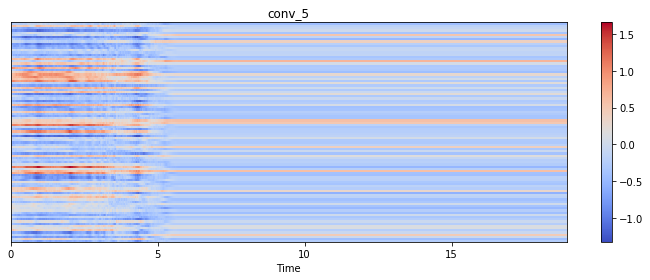

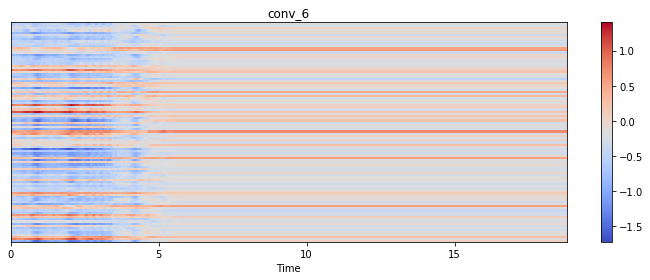

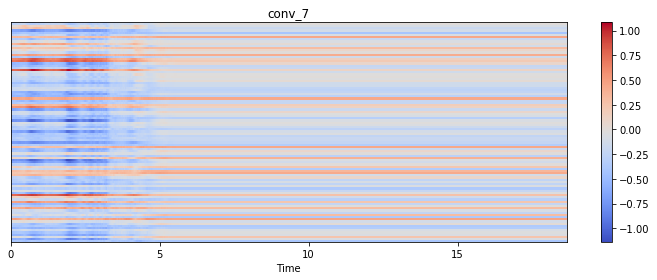

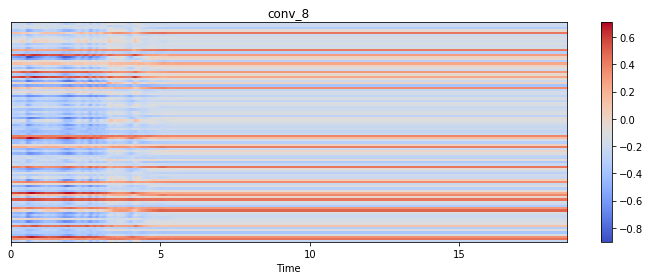

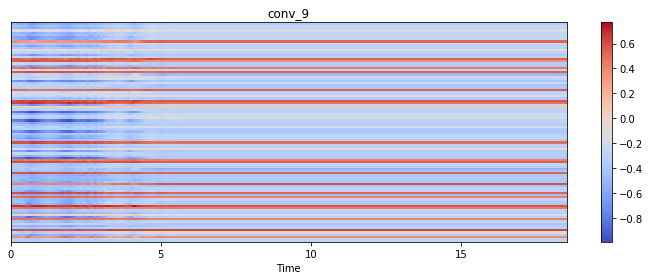

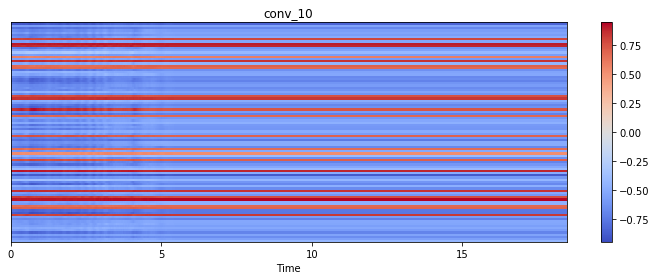

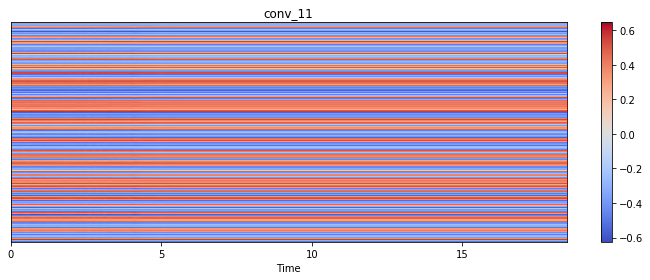

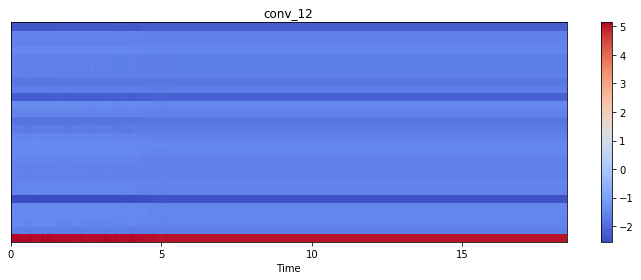

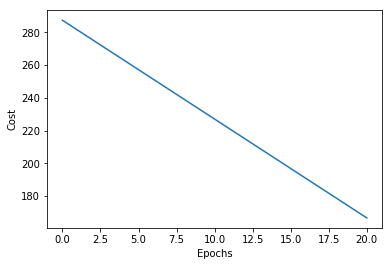

Number of epochs: 42
42
42
42


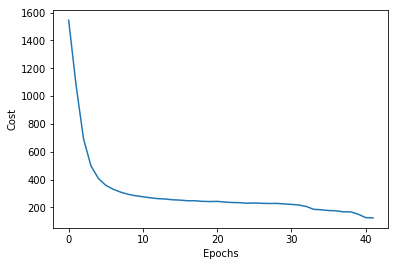

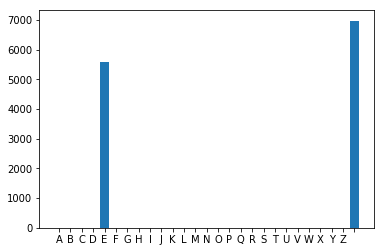

Number of epochs: 44
44
44
44


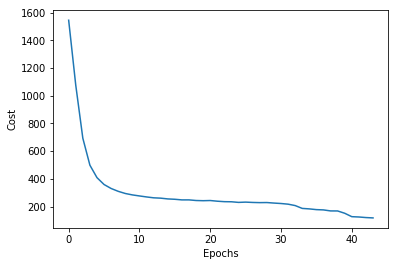

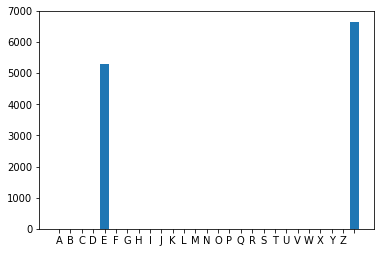

Number of epochs: 46
46
46
46


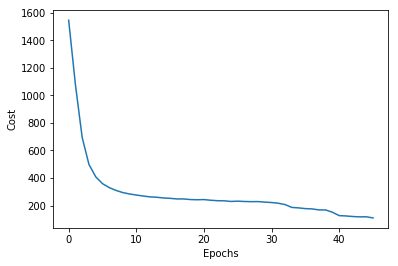

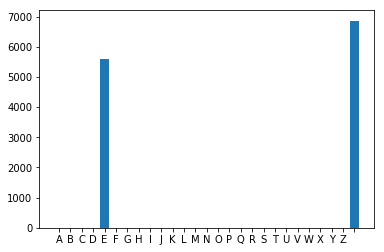

Number of epochs: 48
48
48
48


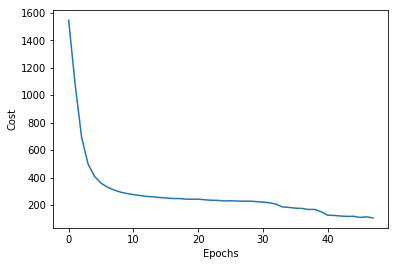

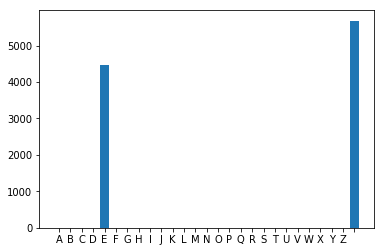

Number of epochs: 50
50
50
50


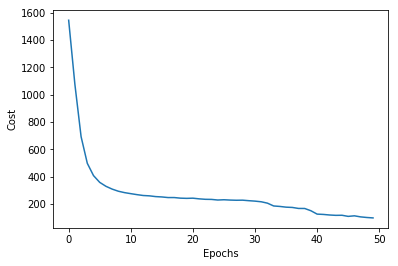

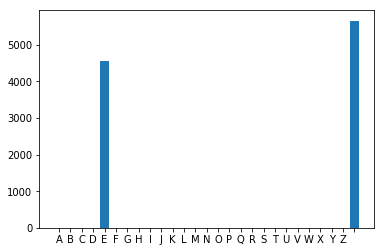

Number of epochs: 52
52
52
52


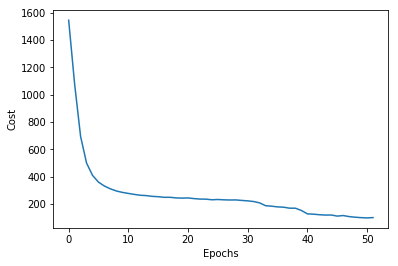

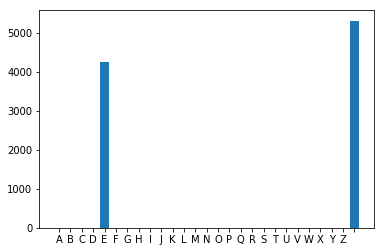

Number of epochs: 54
54
54
54


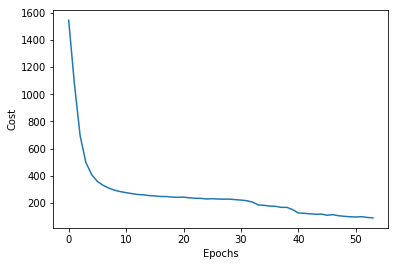

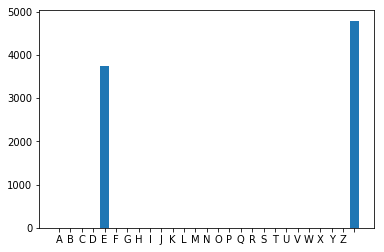

Number of epochs: 56
56
56
56


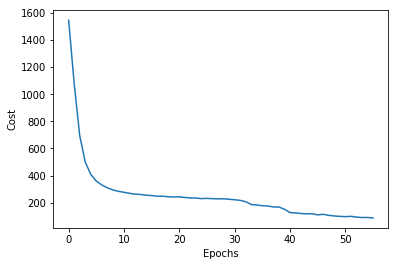

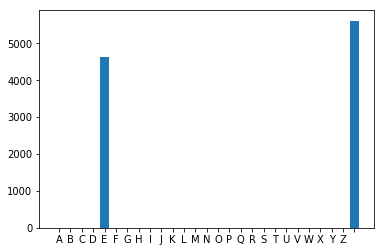

Number of epochs: 58
58
58
58


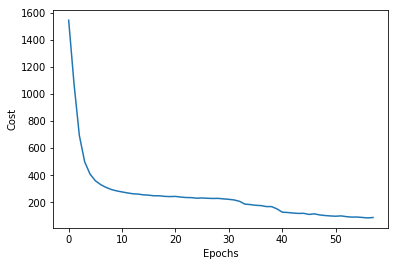

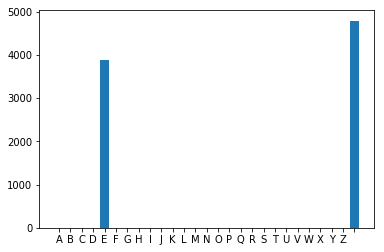

Number of epochs: 60
60
60
60


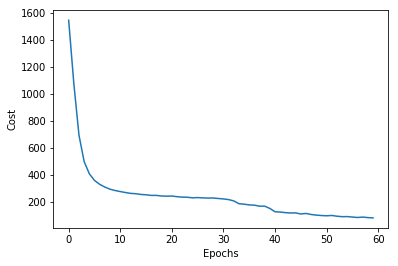

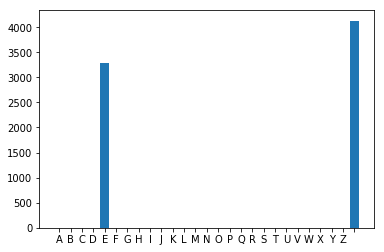

[69, 90, 33, 110, 62, 48, 104, 122, 99, 46, 65, 81, 87, 9, 128, 70, 104, 78, 41, 57, 78, 91, 101, 22, 125, 119, 31, 111, 37, 121, 121, 7, 16, 117, 71, 28, 95, 85, 111, 109]
torch.Size([40, 100, 621])
torch.Size([40, 100, 611])
torch.Size([40, 100, 603])
torch.Size([40, 100, 595])
torch.Size([40, 100, 591])
torch.Size([40, 100, 587])
torch.Size([40, 100, 583])
torch.Size([40, 100, 581])
torch.Size([40, 100, 579])
torch.Size([40, 100, 577])
torch.Size([40, 400, 577])
torch.Size([40, 28, 577])
torch.Size([40, 577, 28])
Predicted: 
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
inf
Predicted: 
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
inf
Predicted: 
Ground truth: P L E A S A N T H I L L S
WER: 
inf
Predicted: 
Ground truth: E R I C
WER: 
inf
Predicted:  E 
Ground truth: ENTER NINE TWO EIGHT
WER: 
17.0
Predicted: E E 
Ground truth: K A U F M A N
WER: 
5.5
Predicted:  E  E 
Ground truth: TWO FORTY
WER: 
4.0
Predicted: 
Ground truth: T R T F I SEVEN
WER: 
inf
Predic

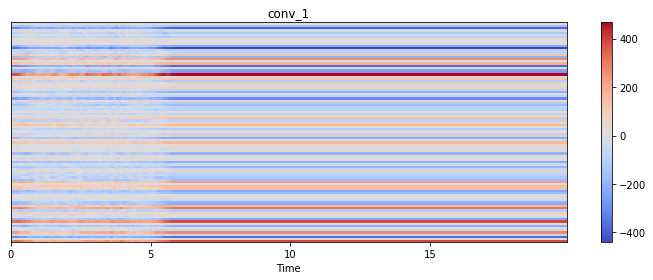

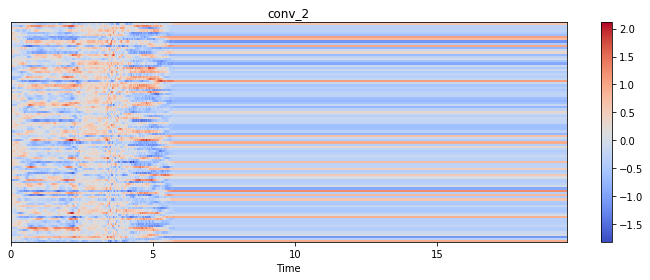

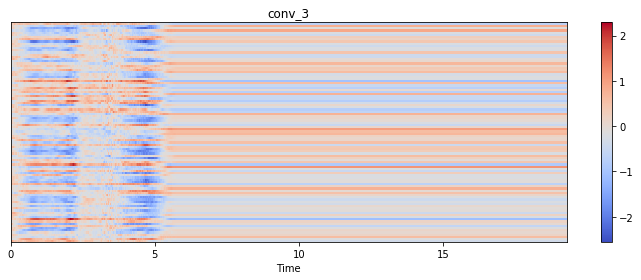

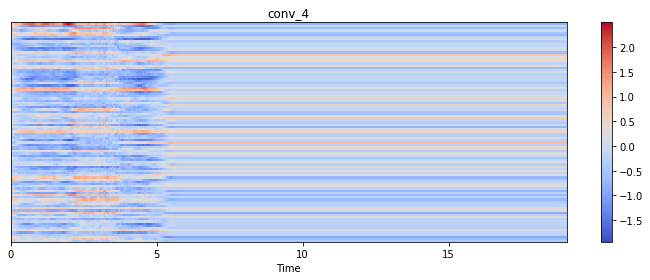

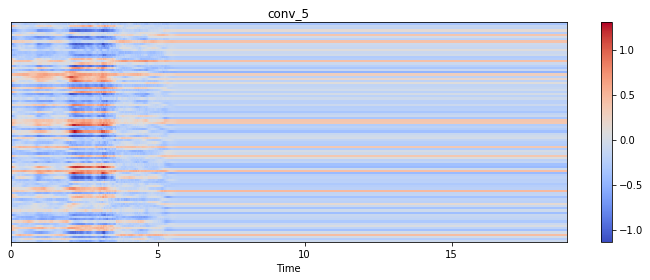

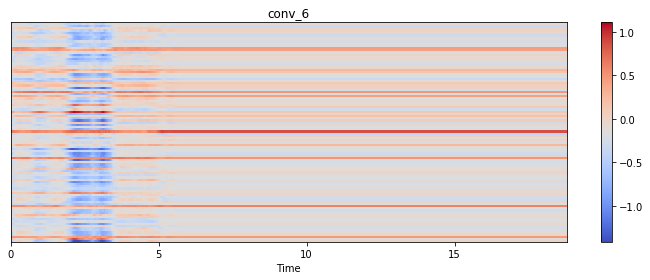

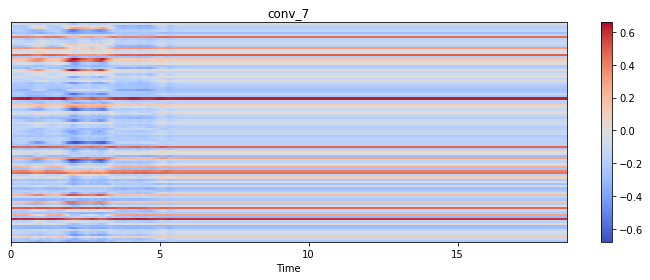

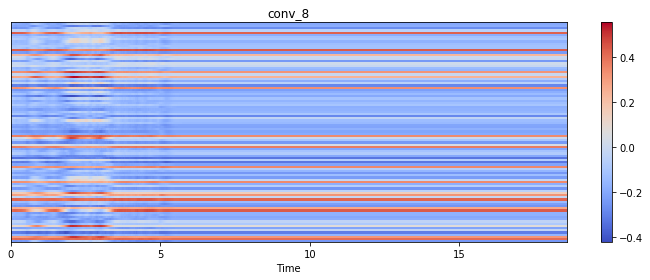

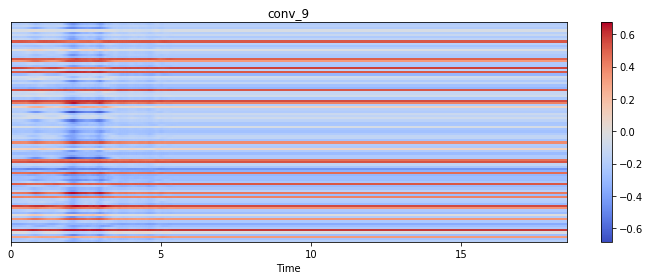

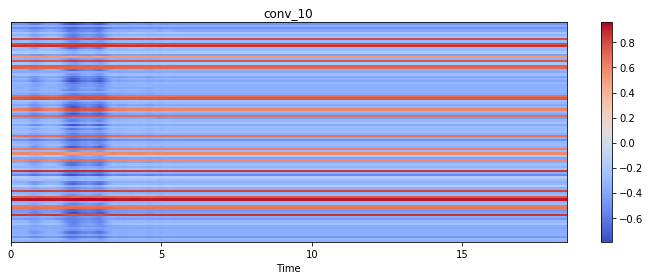

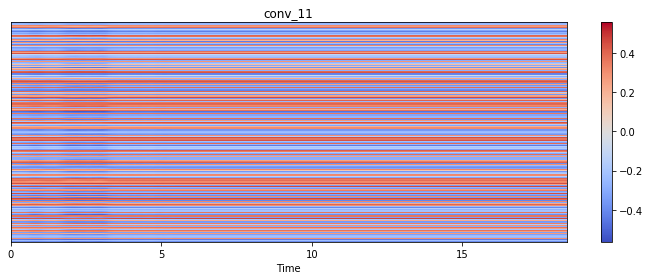

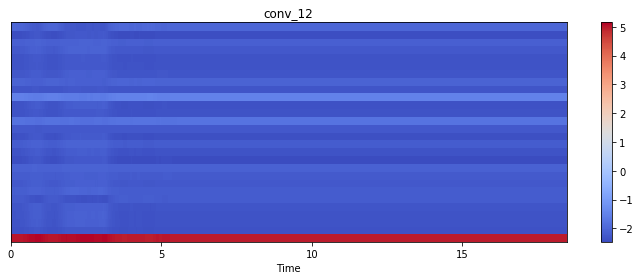

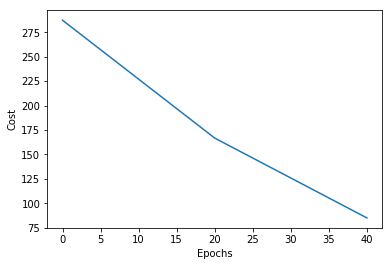

Number of epochs: 62
62
62
62


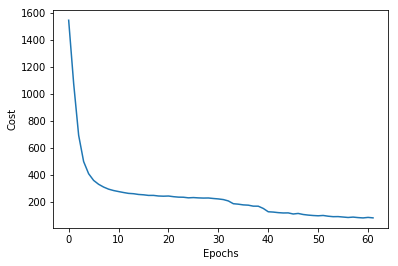

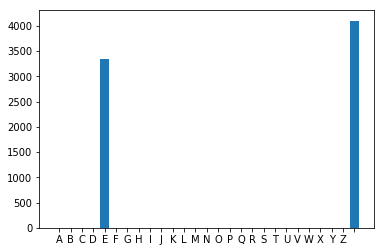

Number of epochs: 64
64
64
64


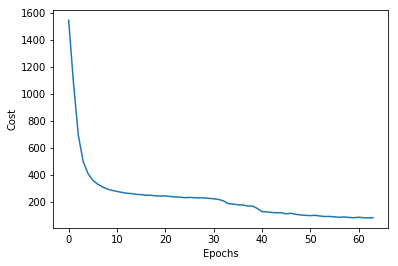

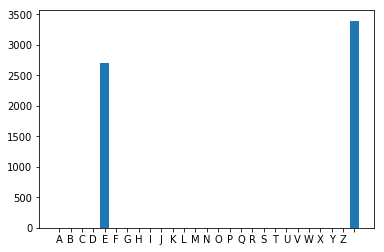

Number of epochs: 66
66
66
66


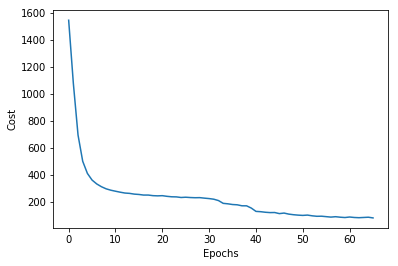

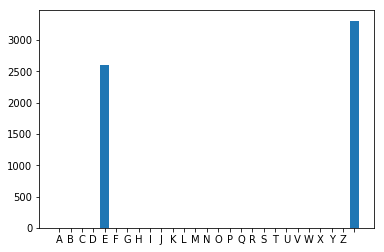

Number of epochs: 68
68
68
68


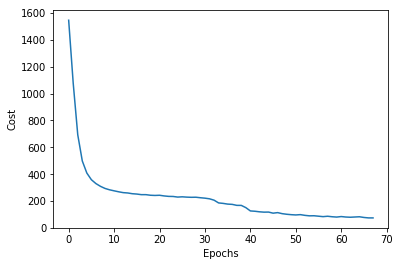

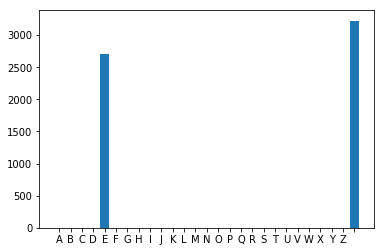

Number of epochs: 70
70
70
70


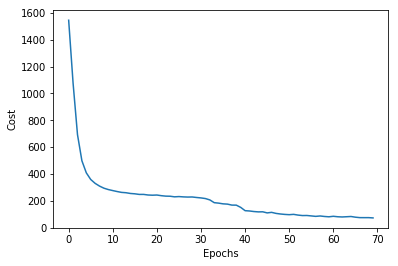

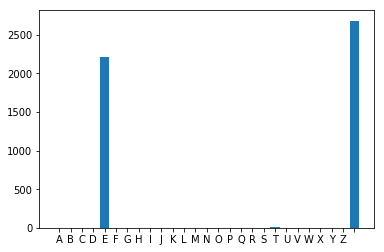

Number of epochs: 72
72
72
72


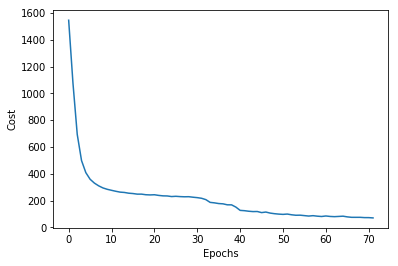

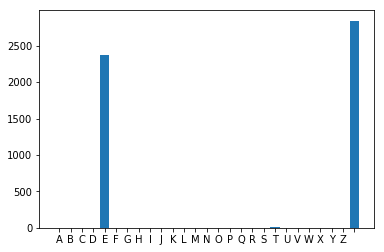

Number of epochs: 74
74
74
74


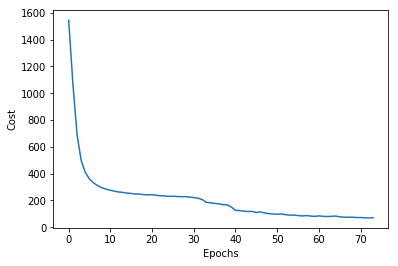

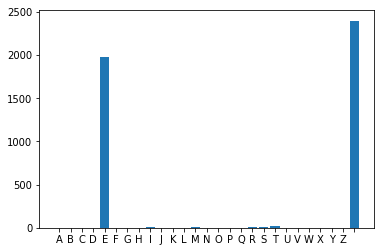

Number of epochs: 76
76
76
76


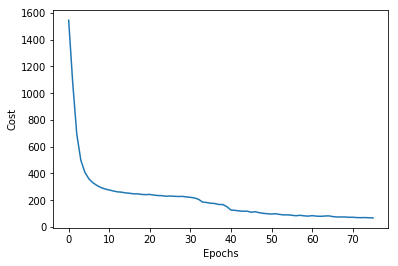

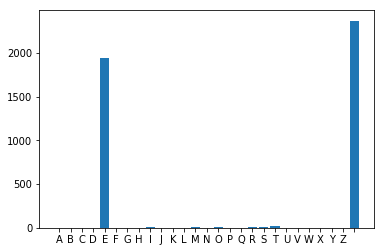

Number of epochs: 78
78
78
78


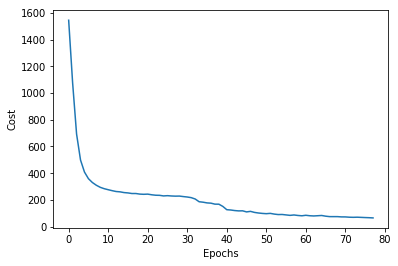

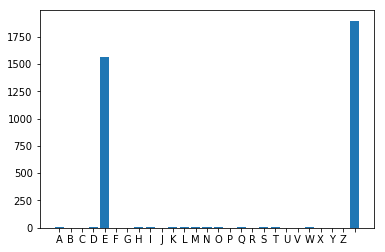

Number of epochs: 80
80
80
80


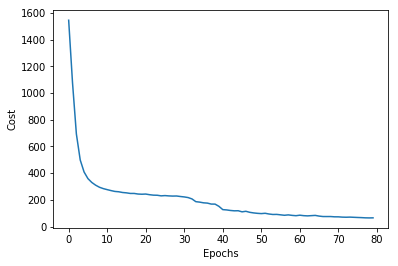

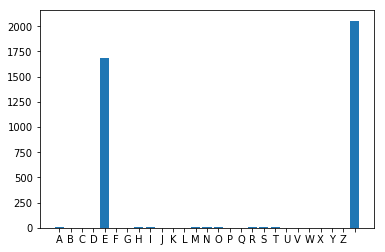

[118, 9, 49, 70, 62, 53, 60, 56, 87, 7, 47, 17, 118, 76, 21, 109, 87, 123, 66, 81, 68, 50, 77, 103, 70, 15, 89, 103, 119, 39, 18, 65, 110, 110, 34, 66, 39, 54, 30, 18]
torch.Size([40, 100, 621])
torch.Size([40, 100, 611])
torch.Size([40, 100, 603])
torch.Size([40, 100, 595])
torch.Size([40, 100, 591])
torch.Size([40, 100, 587])
torch.Size([40, 100, 583])
torch.Size([40, 100, 581])
torch.Size([40, 100, 579])
torch.Size([40, 100, 577])
torch.Size([40, 400, 577])
torch.Size([40, 28, 577])
torch.Size([40, 577, 28])
Predicted: 
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
inf
Predicted: 
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
inf
Predicted: 
Ground truth: P L E A S A N T H I L L S
WER: 
inf
Predicted: 
Ground truth: E R I C
WER: 
inf
Predicted: 
Ground truth: ENTER NINE TWO EIGHT
WER: 
inf
Predicted: 
Ground truth: K A U F M A N
WER: 
inf
Predicted:  E  E 
Ground truth: TWO FORTY
WER: 
4.0
Predicted: 
Ground truth: T R T F I SEVEN
WER: 
inf
Predicted: 
Ground 

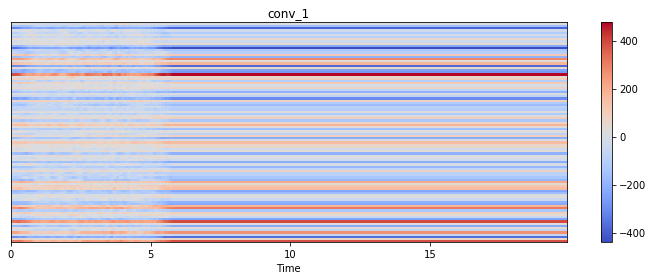

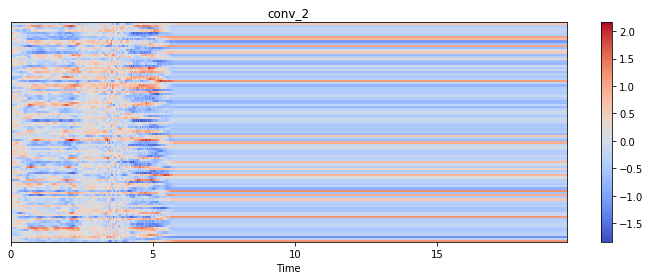

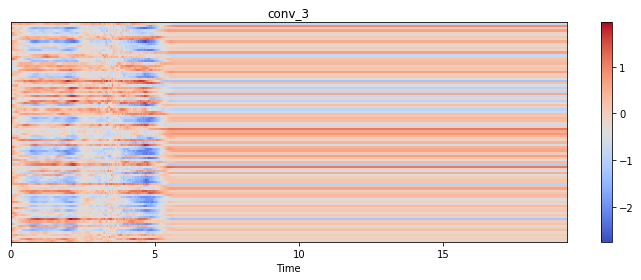

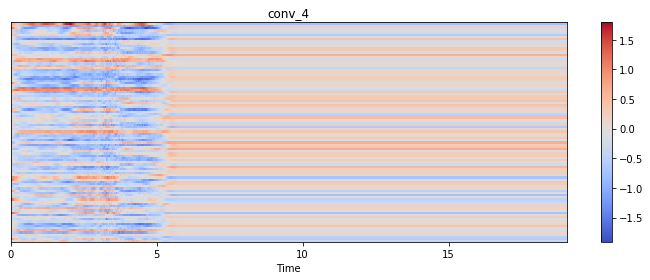

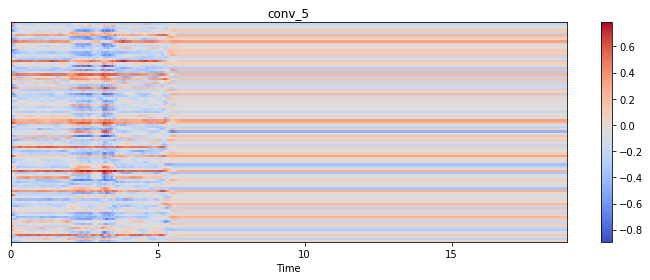

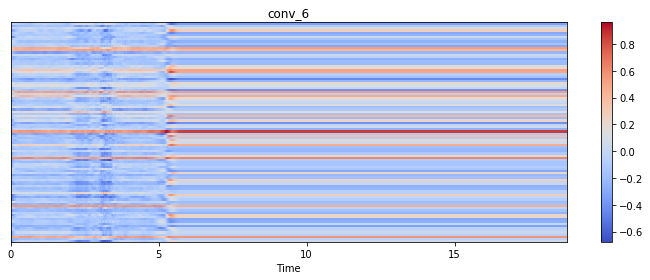

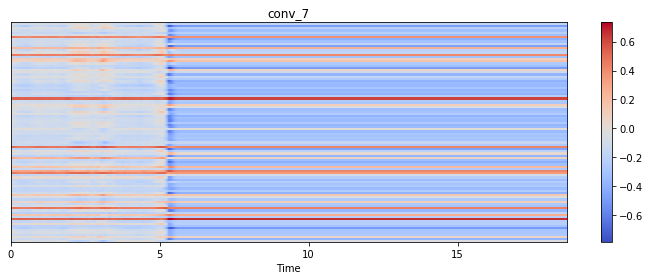

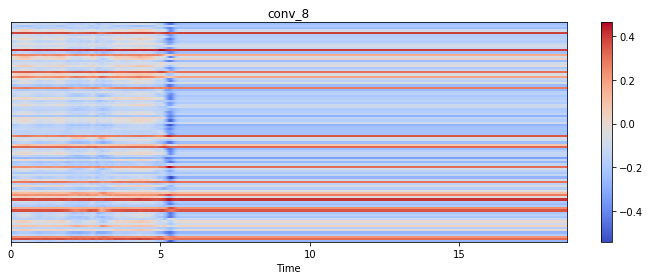

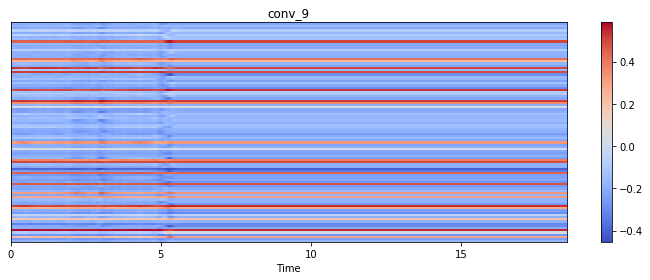

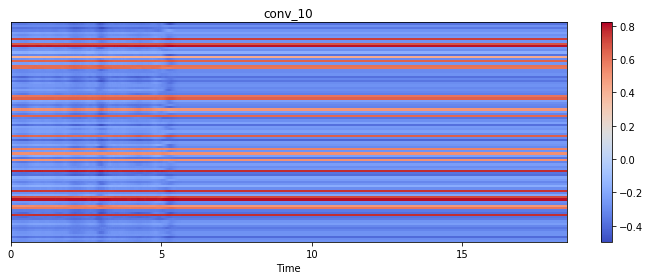

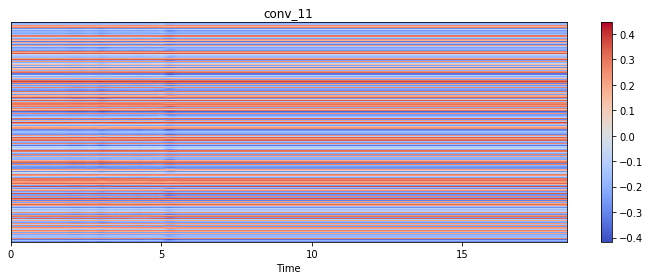

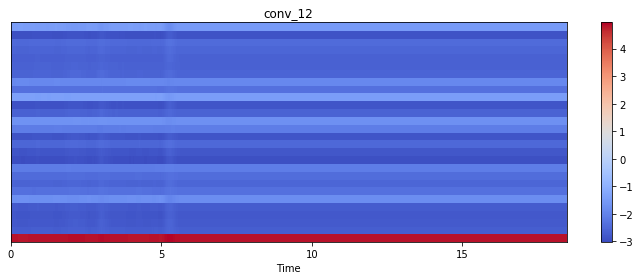

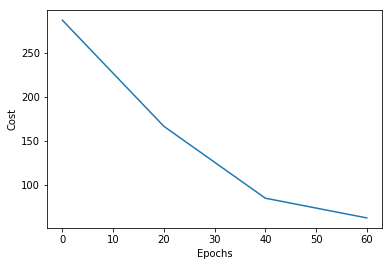

Number of epochs: 82
82
82
82


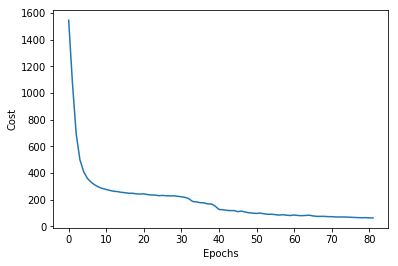

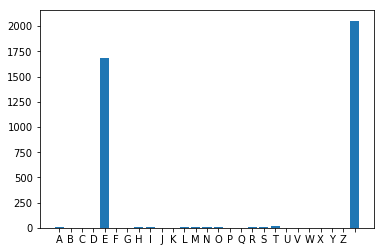

Number of epochs: 84
84
84
84


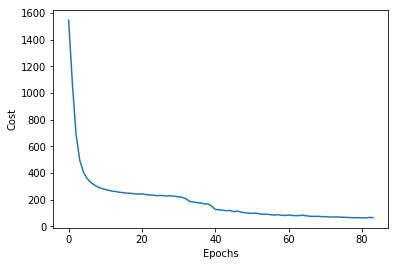

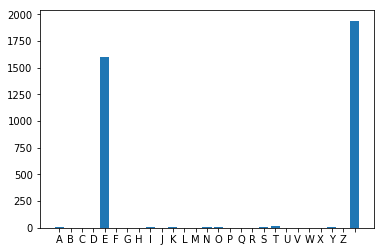

Number of epochs: 86
86
86
86


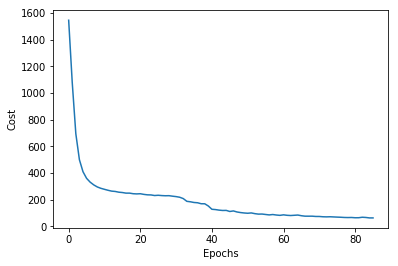

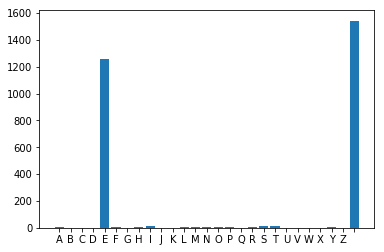

Number of epochs: 88
88
88
88


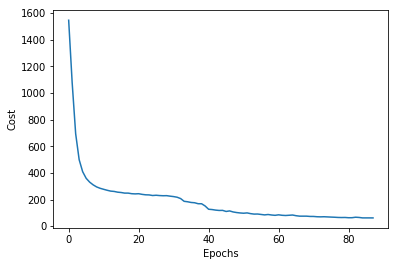

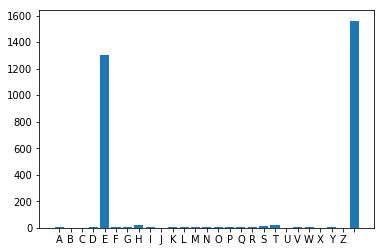

Number of epochs: 90
90
90
90


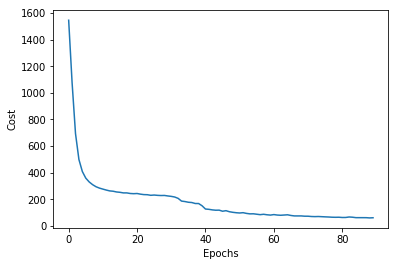

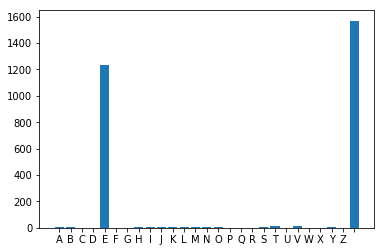

Number of epochs: 92
92
92
92


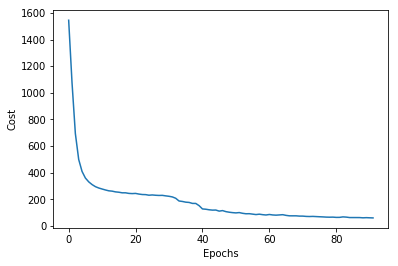

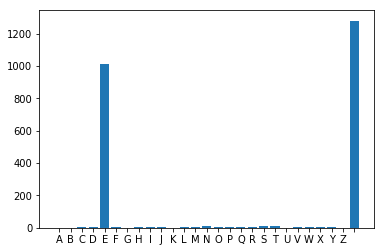

Number of epochs: 94
94
94
94


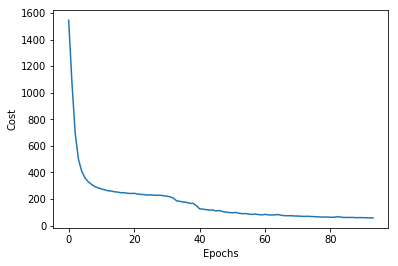

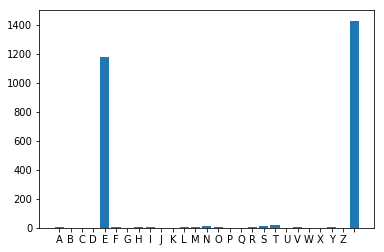

Number of epochs: 96
96
96
96


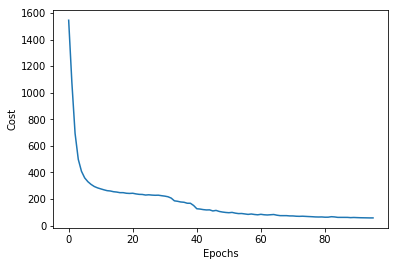

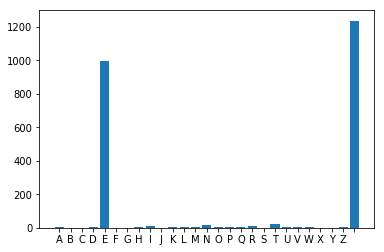

Number of epochs: 98
98
98
98


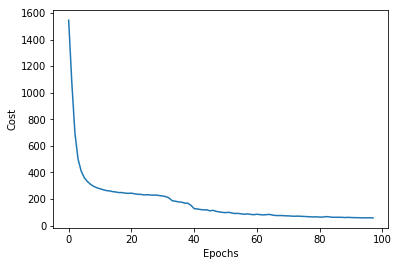

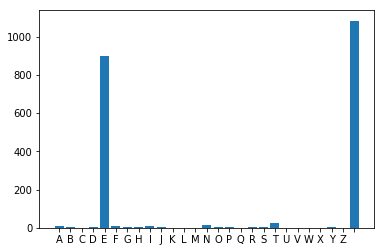

Number of epochs: 100
100
100
100


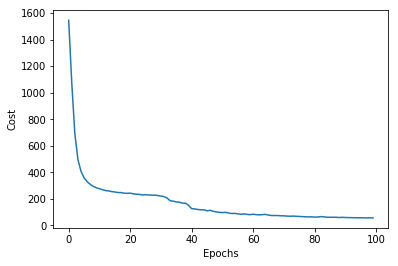

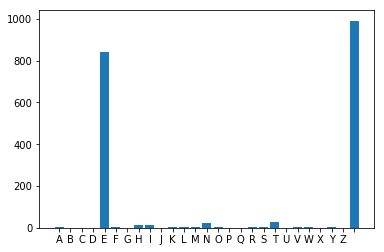

[127, 12, 47, 57, 116, 117, 109, 96, 45, 14, 9, 18, 107, 16, 50, 30, 1, 30, 37, 85, 109, 78, 124, 83, 130, 47, 19, 92, 65, 116, 74, 128, 36, 117, 23, 76, 5, 85, 67, 44]
torch.Size([40, 100, 621])
torch.Size([40, 100, 611])
torch.Size([40, 100, 603])
torch.Size([40, 100, 595])
torch.Size([40, 100, 591])
torch.Size([40, 100, 587])
torch.Size([40, 100, 583])
torch.Size([40, 100, 581])
torch.Size([40, 100, 579])
torch.Size([40, 100, 577])
torch.Size([40, 400, 577])
torch.Size([40, 28, 577])
torch.Size([40, 577, 28])
Predicted: 
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
inf
Predicted: 
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
inf
Predicted: 
Ground truth: P L E A S A N T H I L L S
WER: 
inf
Predicted: 
Ground truth: E R I C
WER: 
inf
Predicted: 
Ground truth: ENTER NINE TWO EIGHT
WER: 
inf
Predicted: 
Ground truth: K A U F M A N
WER: 
inf
Predicted: E  E 
Ground truth: TWO FORTY
WER: 
4.0
Predicted: 
Ground truth: T R T F I SEVEN
WER: 
inf
Predicted: 
Ground 

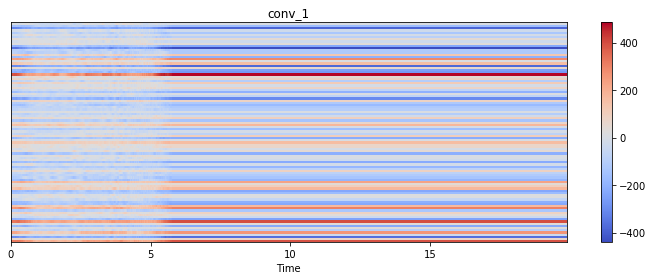

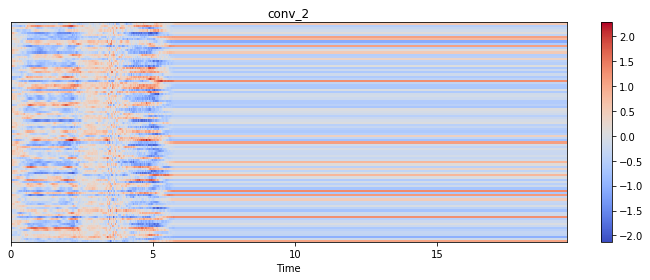

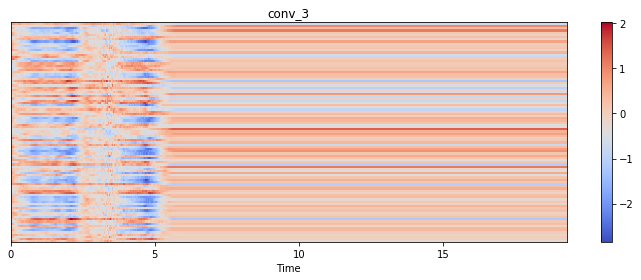

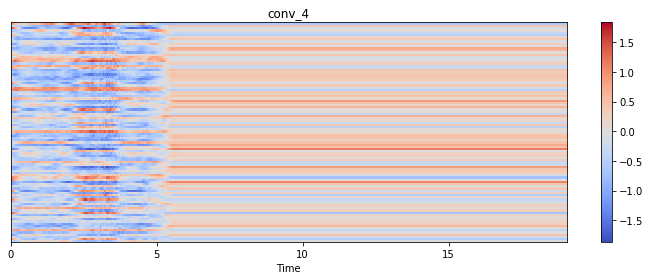

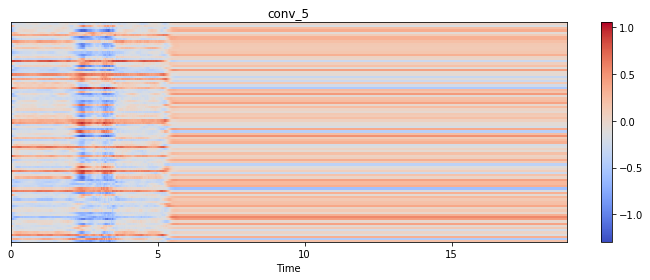

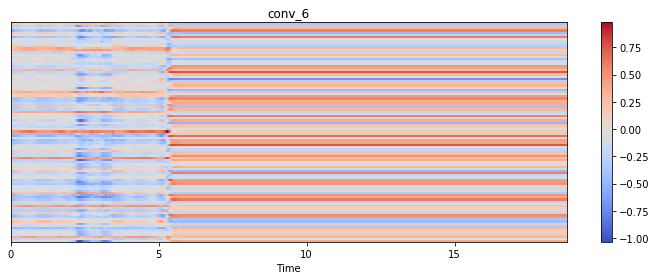

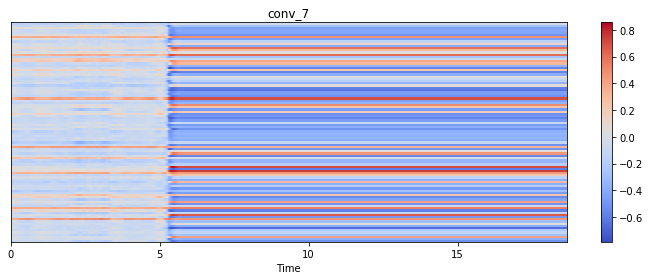

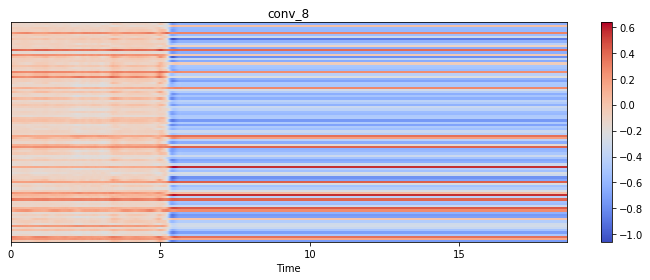

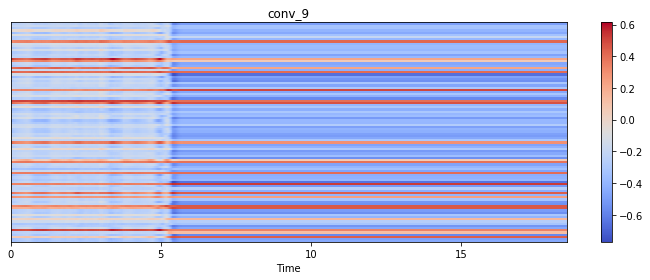

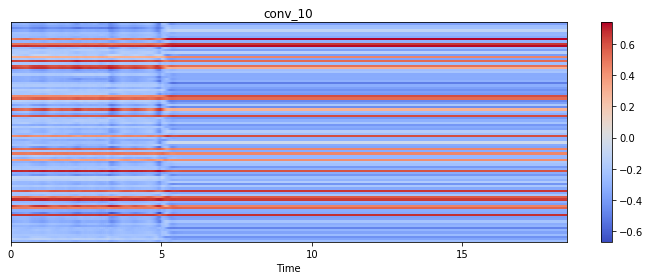

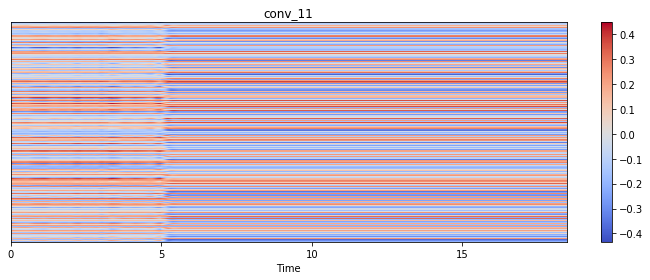

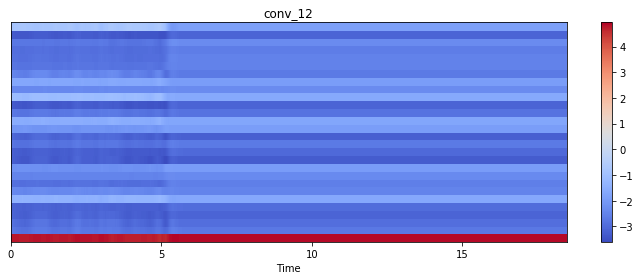

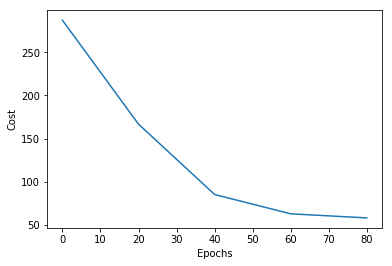


  [A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z,  , -
A [5, 7, 30, 14, 4005, 21, 11, 13, 17, 9, 16, 30, 6, 18, 56, 19, 27, 5003, 15, 47, 16, 9, 7, 28, 23, 14, 5256, 14878]
B [10, 8, 15, 5, 2153, 14, 8, 7, 18, 10, 9, 13, 9, 13, 32, 6, 21, 3430, 15, 26, 8, 8, 3, 16, 9, 2, 3629, 8703]
C [1, 4, 1, 3, 1321, 3, 4, 8, 8, 2, 7, 3, 3, 4, 18, 7, 8, 1410, 6, 14, 2, 4, 5, 9, 10, 1, 1630, 3804]
D [5, 4, 20, 4, 1243, 14, 7, 8, 12, 8, 6, 8, 10, 6, 30, 12, 10, 1401, 8, 21, 9, 4, 6, 12, 11, 1, 1425, 10095]
E [67, 91, 247, 76, 32462, 203, 95, 102, 231, 66, 92, 219, 117, 114, 469, 104, 156, 21552, 130, 330, 113, 69, 98, 201, 222, 63, 25252, 135859]
F [18, 28, 55, 21, 6355, 47, 32, 26, 51, 23, 33, 57, 34, 36, 108, 24, 40, 6970, 33, 74, 28, 18, 21, 49, 54, 12, 7939, 32514]
G [12, 16, 30, 9, 2849, 19, 7, 14, 27, 11, 15, 31, 15, 11, 62, 18, 18, 3068, 14, 45, 9, 8, 15, 32, 36, 8, 3419, 19582]
H [13, 20, 74, 24, 8329, 68, 15, 33, 62, 19, 28, 70, 34, 39, 124, 22, 56, 5146, 35, 7

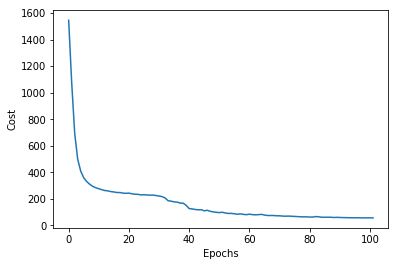

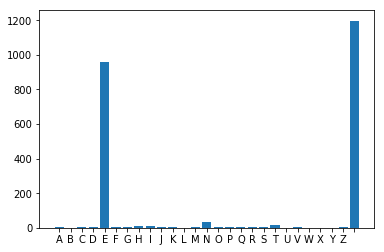

Number of epochs: 104
104
104
104


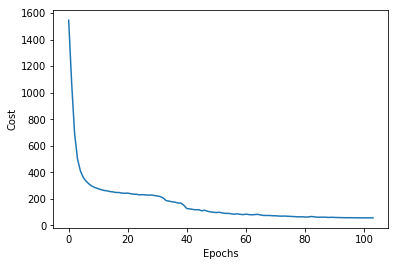

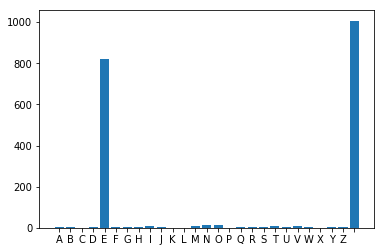

Number of epochs: 106
106
106
106


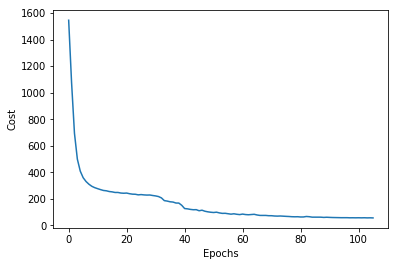

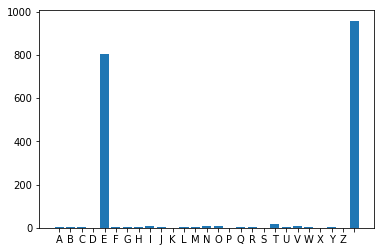

Number of epochs: 108
108
108
108


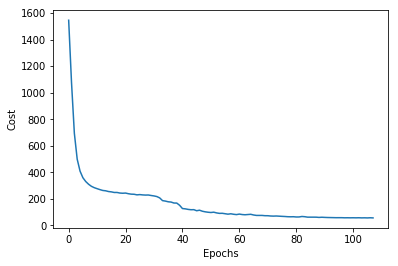

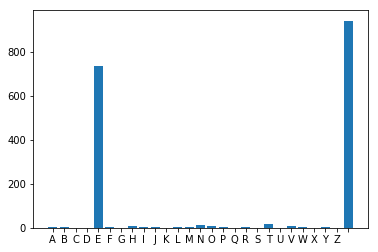

Number of epochs: 110
110
110
110


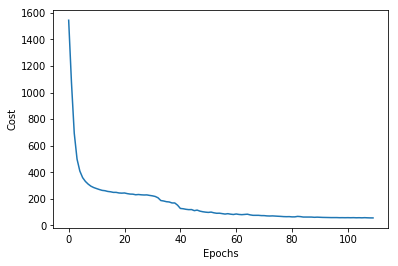

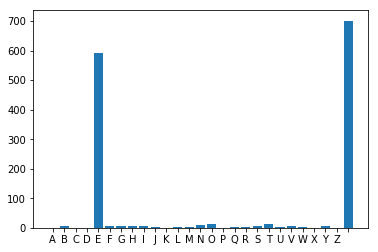

Number of epochs: 112
112
112
112


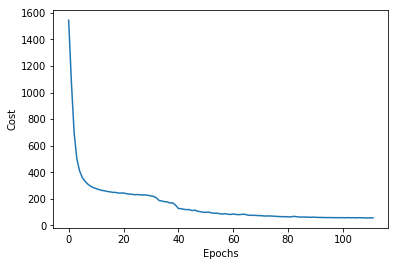

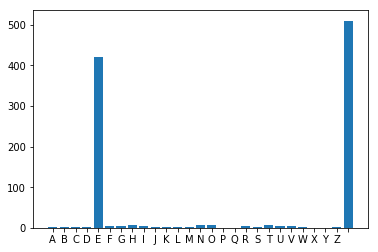

Number of epochs: 114
114
114
114


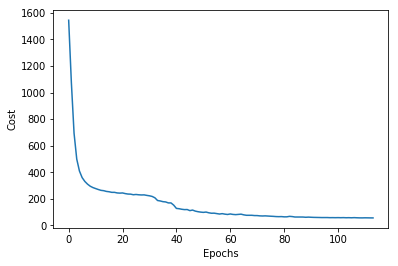

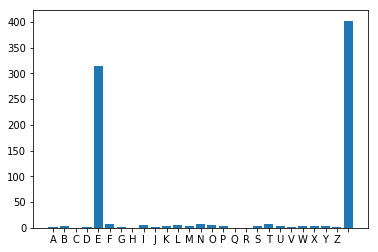

Number of epochs: 116
116
116
116


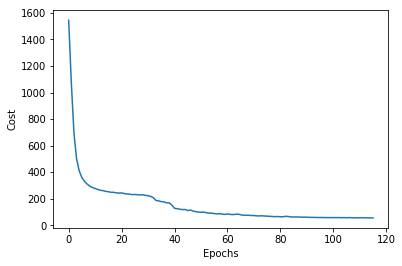

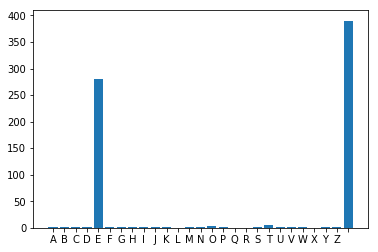

Number of epochs: 118
118
118
118


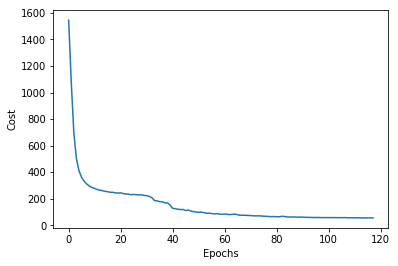

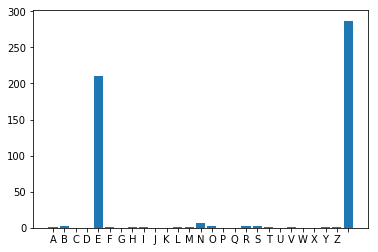

Number of epochs: 120
120
120
120


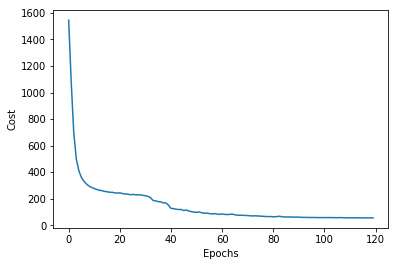

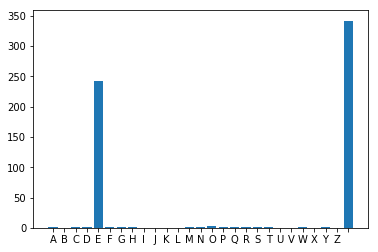

[91, 16, 90, 102, 16, 79, 18, 91, 56, 82, 92, 17, 61, 0, 114, 70, 5, 71, 93, 116, 0, 130, 96, 3, 97, 53, 54, 13, 22, 4, 0, 41, 45, 44, 27, 98, 3, 48, 54, 21]
torch.Size([40, 100, 621])
torch.Size([40, 100, 611])
torch.Size([40, 100, 603])
torch.Size([40, 100, 595])
torch.Size([40, 100, 591])
torch.Size([40, 100, 587])
torch.Size([40, 100, 583])
torch.Size([40, 100, 581])
torch.Size([40, 100, 579])
torch.Size([40, 100, 577])
torch.Size([40, 400, 577])
torch.Size([40, 28, 577])
torch.Size([40, 577, 28])
Predicted: 
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
inf
Predicted: 
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
inf
Predicted: 
Ground truth: P L E A S A N T H I L L S
WER: 
inf
Predicted: 
Ground truth: E R I C
WER: 
inf
Predicted: 
Ground truth: ENTER NINE TWO EIGHT
WER: 
inf
Predicted: 
Ground truth: K A U F M A N
WER: 
inf
Predicted: E 
Ground truth: TWO FORTY
WER: 
8.0
Predicted: 
Ground truth: T R T F I SEVEN
WER: 
inf
Predicted: 
Ground truth: ONE FIV

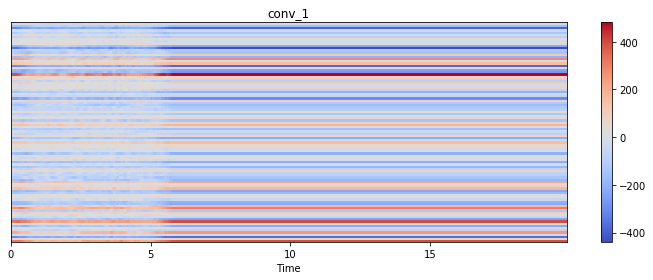

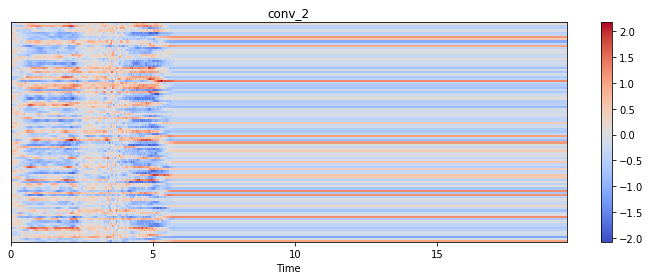

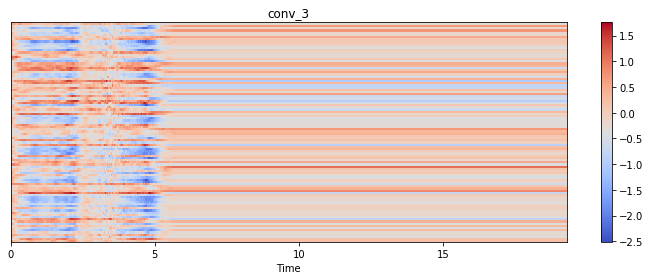

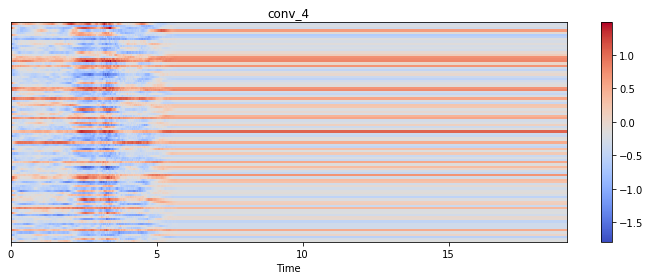

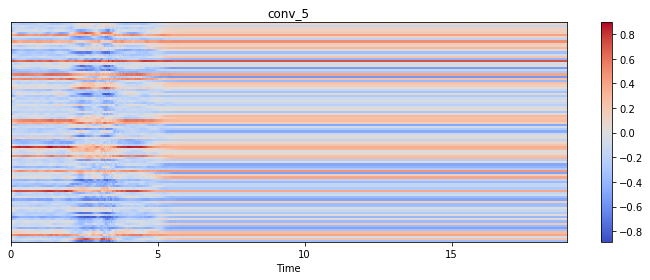

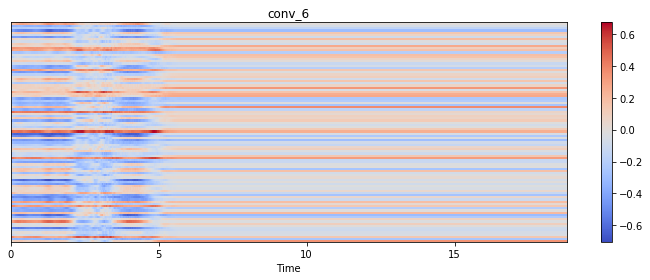

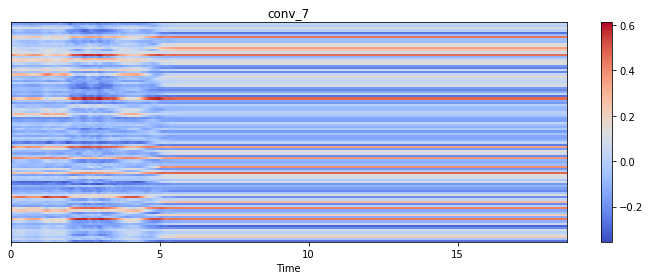

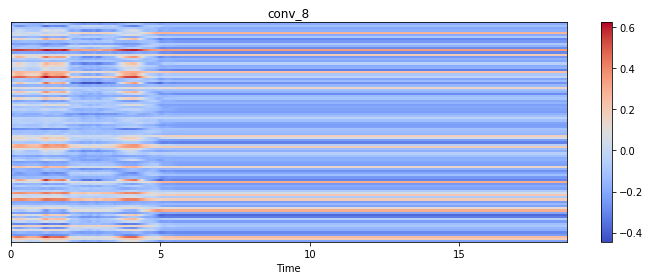

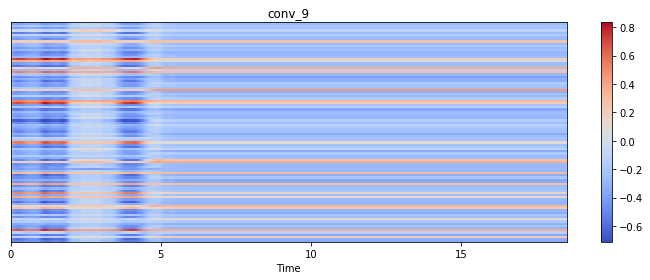

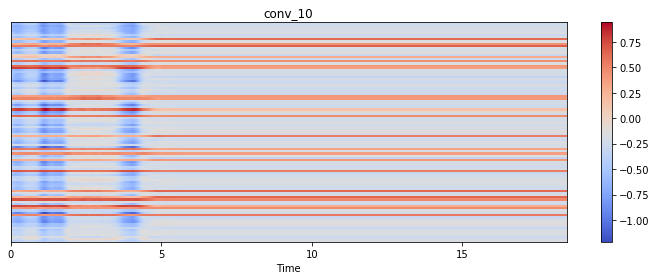

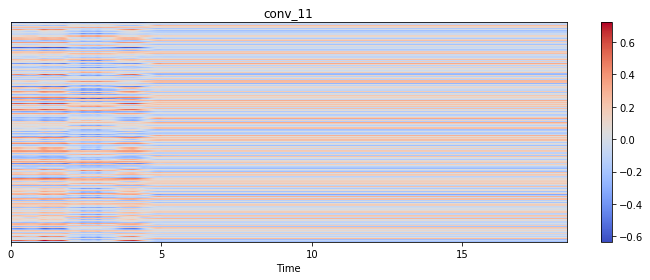

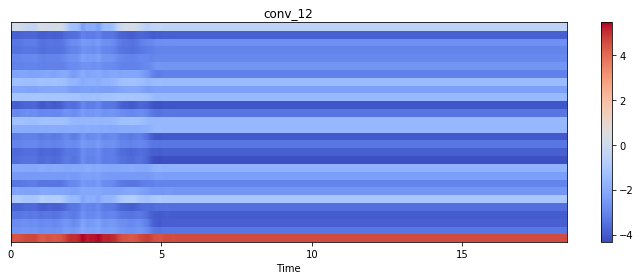

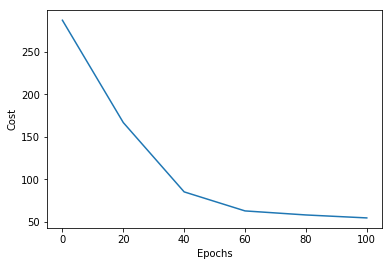

Number of epochs: 122
122
122
122


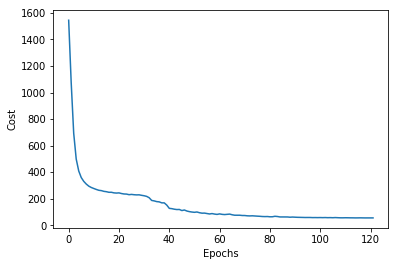

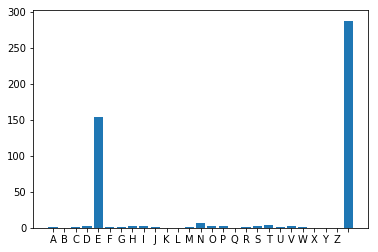

In [ ]:
counter = 0

torch.set_default_tensor_type('torch.FloatTensor')

hist_predicted = []

costs=[]
costs_eval=[]
num_evals=1
epoch=0
comparisons = []

for i in range(28):
    row = []
    for j in range(28):
        row.append(0)
    comparisons.append(row)

while epoch < num_epochs:
    hist_preds = [0]*27
    for i in range(int(num_samples/batch_size)):
        net.train()

        sample = numpy.empty([batch_size,width, 641])
        
        ground_truth_sizes = torch.empty(batch_size)
        probs_sizes = torch.empty(batch_size)
        
        ground_truth_string_int = []
        avg_cost=0
        for j in range(batch_size):
            samp = numpy.asarray(Ms[i * batch_size + j][0], dtype=numpy.float32)
            sample[j] = samp
            
            string = ''.join(labels[i * batch_size + j])

            ground_truth_sizes[j] = len(string)
            
            for character in string:
                if(character == " "):
                    number = 27
                else:
                    number = ord(character) - 64
                ground_truth_string_int.append(number)
        #print(sample.shape)
        
        input_sample=torch.from_numpy(sample)
        
        
        #print(input_sample.shape)
        #print("Len of truth: " + str(len(ground_truth_string_int)))
        #print("sum of truths: " + str(sum(ground_truth_sizes)))

        ground_truth = torch.IntTensor(ground_truth_string_int)
        #print("going into network.")
        #print(input_sample)
        out = net(Variable(input_sample).float(), False)
        
        
        
        for j in range(batch_size):
            probs_sizes[j]=out.shape[1]
        
        for j, pred in enumerate(out): 
            if (epoch %100==0 and epoch > 0 and i == 0 and j == 0):
                print(''.join(greedy_decoder(torch.nn.functional.log_softmax(pred, dim=1), all_labels)))
                print_comparisons(matrix=comparisons)
            hist_preds = add_string_to_histogram(hist_preds, greedy_decoder(torch.nn.functional.log_softmax(pred, dim=1), all_labels))
            comparisons = prediction_comparator(comparisons, truth=''.join(labels[i*batch_size + j]),predicted=''.join(greedy_decoder(torch.nn.functional.log_softmax(pred, dim=1), all_labels)))
        #print("out:")
        #print(out.shape)
        
        #print("probs sizes: " + str(probs_sizes))

        #run the criterion
        optimizer.zero_grad()

        #print(ground_truth.shape)
        #input must be in shape seq_length x batch size x outputs -> 641 x 1 x 28/27 (depends if we use spaces or not)
        cost=criterion(out.transpose(0,1), torch.tensor(ground_truth_string_int).int(), probs_sizes.int(), ground_truth_sizes.int())
        cost.backward()
        optimizer.step()
        #print(cost)
        #greedy_decoder(out[0], all_labels)
        avg_cost = avg_cost+cost.item()/batch_size
        
    #print(avg_cost)
    avg_cost=avg_cost
    epoch = epoch + 1
    costs.append(avg_cost)
    
    
    #plots the average cost
    if(epoch%2 == 0 and epoch > 0):
        print("Number of epochs: "  + str(epoch))
        display_cost(costs, epoch)
        plot_histogram(hist_preds)
    error_rates=[]

    #evaluation not really implemented yet.    
    if(epoch%valid_epochs == 0):
        net.eval()
        with torch.no_grad():
            indices = [0]*batch_size
            
            for j in range(batch_size):
                indices[j] = random.randint(0, len(Ms_valid) - 1)
            print(indices)
            
            sample = numpy.empty([batch_size,width, 641])
            ground_truth_string_int = []
            ground_truth_sizes = torch.empty(batch_size)
            probs_sizes = torch.empty(batch_size)
        
                
            avg_error_rate = 0
            for j in range(batch_size):
                sample[j] = Ms_valid[j][0]

                string = ''.join(labels[i * batch_size + j])
                ground_truth_sizes[j] = len(string)

                
                
                
                for character in string:
                    if(character == " "):
                        number = 27
                    else:
                        number = ord(character) - 64
                    ground_truth_string_int.append(number)

            outs, out = net(Variable(torch.from_numpy(sample).float()), True)
                
            for j in range(batch_size):
                   probs_sizes[j]=out.shape[1]
            for k, res in enumerate(outs):
                print(res.shape)
                plt.figure(figsize=(10, 4))
                librosa.display.specshow(res[0].detach().numpy(), x_axis='time', sr=16000)
                plt.colorbar()
                plt.title('conv_'+str(k+1))
                plt.tight_layout()
                
            print(out.shape)
                
            cost=criterion(out.transpose(0,1), torch.tensor(ground_truth_string_int).int(), probs_sizes.int(), ground_truth_sizes.int())
        
            costs_eval.append(cost/batch_size)
            
            for j in range(batch_size):
                ground_truth = ''.join(labels_valid[j])
                predicted = ''.join(greedy_decoder(out[j], all_labels))
                print("Predicted: " + predicted)
                print("Ground truth: " + ground_truth)
                wer = WER(predicted, ground_truth)
                print("WER: ")
                print(wer)
                avg_error_rate = avg_error_rate + wer
                
            print("Eval loss: ")
            display_cost_eval(costs_eval, epoch, valid_epochs)
                
            num_evals += 1

            avg_error_rate/batch_size
            error_rates.append(avg_error_rate)
        

In [ ]:
net.eval()
with torch.no_grad():
    sample_train = numpy.empty([1,width, 641])
    print(Ms[0][0].shape)
    print(sample_train.shape)
    sample_train[0] = Ms[0][0]
    input_sample = torch.from_numpy(sample_train)
    outs, out = net(Variable(input_sample).float(), True)
    
    
    
    
    #librosa.display.specshow(x_2[0].detach().numpy(), x_axis='time')
    #librosa.display.specshow(x_3[0].detach().numpy(), x_axis='time')
    #librosa.display.specshow(x_4[0].detach().numpy(), x_axis='time')
    #librosa.display.specshow(x_5[0].detach().numpy(), x_axis='time')
    #librosa.display.specshow(x_6[0].detach().numpy(), x_axis='time')
    #librosa.display.specshow(x_7[0].detach().numpy(), x_axis='time')
    #librosa.display.specshow(x_8[0].detach().numpy(), x_axis='time')
    #librosa.display.specshow(x_9[0].detach().numpy(), x_axis='time')
    #librosa.display.specshow(x_10[0].detach().numpy(), x_axis='time')
    

# References

Up until this point we used various different libraries.

* For CTC cost we are using a warp-ctc function created by BAIDU which was recommended here: https://distill.pub/2017/ctc/
* It was also used in DeepSpeech: https://github.com/SeanNaren/deepspeech.pytorch - we use different architecture and many things are different, since warp-ctc does not contain much documentation, we had to check out the implementation. In the end this one was only useful to search for the libraries.

* Libraries we used:

  * warp-ctc pytorch binding - to know how to use this one, we had to play with the unit tests, since the library hardly contains any documentation.
  
  https://github.com/SeanNaren/warp-ctc
  
  * ctcdecode - for beamsearch to construct the string in the evaluation. We still have problem to understand how to build it properly though.
  
  https://github.com/githubharald/CTCDecoder
  
  * Both of the libraries lack much documentation are difficult to understand

In [67]:
print(type(Ms[0][0]))

<type 'numpy.ndarray'>
